# Assignment: CSCA 5632 Unsupervised Algorithms for Customer Segmentation and Recommendation Systems

## Introduction

E-commerce businesses generate vast amounts of transaction data, but extracting meaningful insights from this data remains challenging. Key business goals include understanding customer behavior, providing personalized product recommendations, and predicting future purchases. Addressing these challenges can improve marketing effectiveness, increase customer retention, and boost sales.

In this assignment, I focus on applying unsupervised machine learning techniques to analyze real-world e-commerce data. The main objectives are:

1. Customer segmentation to distinct groups of customers based on their purchasing behavior.  
2. Product recommendation to suggest relevant items to customers to enhance cross-selling and upselling opportunities.

By exploring these patterns, I aim to demonstrate how data-driven insights can inform better business decisions in online retail.

## Dataset Description

- Dataset: UCI Online Retail Dataset  
- Source: https://archive.ics.uci.edu/dataset/352/online+retail  
- Business Context: Transactions from a UK-based online retailer specializing in gifts, including both individual and wholesale customers.  

This dataset provides a realistic snapshot of e-commerce operations, capturing diverse purchasing behaviors across a range of products.

## Problem Definition

E-commerce businesses collect large volumes of transaction data, but turning this data into actionable insights is not straightforward. Two key challenges are particularly important: understanding different customer groups and making personalized product recommendations.

Without effective segmentation, marketing campaigns tend to be generic, leading to low engagement and wasted advertising budgets. Similarly, poor recommendation systems can result in missed cross-selling opportunities, fewer repeat purchases, and higher customer churn.

In this project, I aim to use unsupervised learning methods, such as clustering based on purchase history and customer behavior, to identify meaningful customer segments. I expect that understanding these segments will help deliver better recommendations, improve customer lifetime value, and increase sales.

## Why I Chose This Dataset

I chose this dataset because it represents real-world e-commerce data, rather than a simplified or synthetic dataset. This means it includes imperfections, inconsistencies, and missing values, which provide an opportunity to practice data cleaning, transformation, and exploratory analysis in a realistic context.

Its richness and complexity make it well-suited for unsupervised learning techniques such as clustering, dimensionality reduction, and matrix factorization. These methods can uncover hidden patterns in customer behavior, purchasing preferences, and product relationships. Working with this dataset allows me to extract practical insights that closely mirror real business scenarios and challenges.


In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score


# Online Retail Data Loading

It loads the **Online Retail** dataset from an Excel file into a Pandas DataFrame.


In [79]:
import os
data_path = 'online_retail.xlsx'

df = pd.read_excel(data_path)
display(df.head())
print(df.dtypes)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object


# Dataset Overview

This shows a quick summary of the dataset using Pandas.


In [80]:

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
print(f"Unique customers: {df['Customer ID'].nunique()}")
print(f"Unique products: {df['Description'].nunique()}")
print(f"Unique countries: {df['Country'].nunique()}")

Dataset shape: (525461, 8)
Date range: 2009-12-01 07:45:00 to 2010-12-09 20:01:00
Unique customers: 4383
Unique products: 4681
Unique countries: 40


# Missing Data Analysis

This code computes the missing values in each column of the dataset and shows missing counts and percentages.


In [81]:
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

             Missing Count  Percentage
Customer ID         107927   20.539488
Description           2928    0.557225


# Exploratory Data Analysis: Online Retail Dataset

This exploratory data analysis gives an overview of customer behavior, product popularity, and sales trends in the Online Retail dataset. Most purchases involve moderate quantities and affordable unit prices, while sales are concentrated in a few key countries. Clear monthly and weekday patterns emerge, with distinct peak hours during the day. A small number of products drive most of the purchases, and revenue distribution is uneven, showing the presence of high-value customers. Overall, customer engagement varies widely, with some buyers being highly active and others purchasing only occasionally.


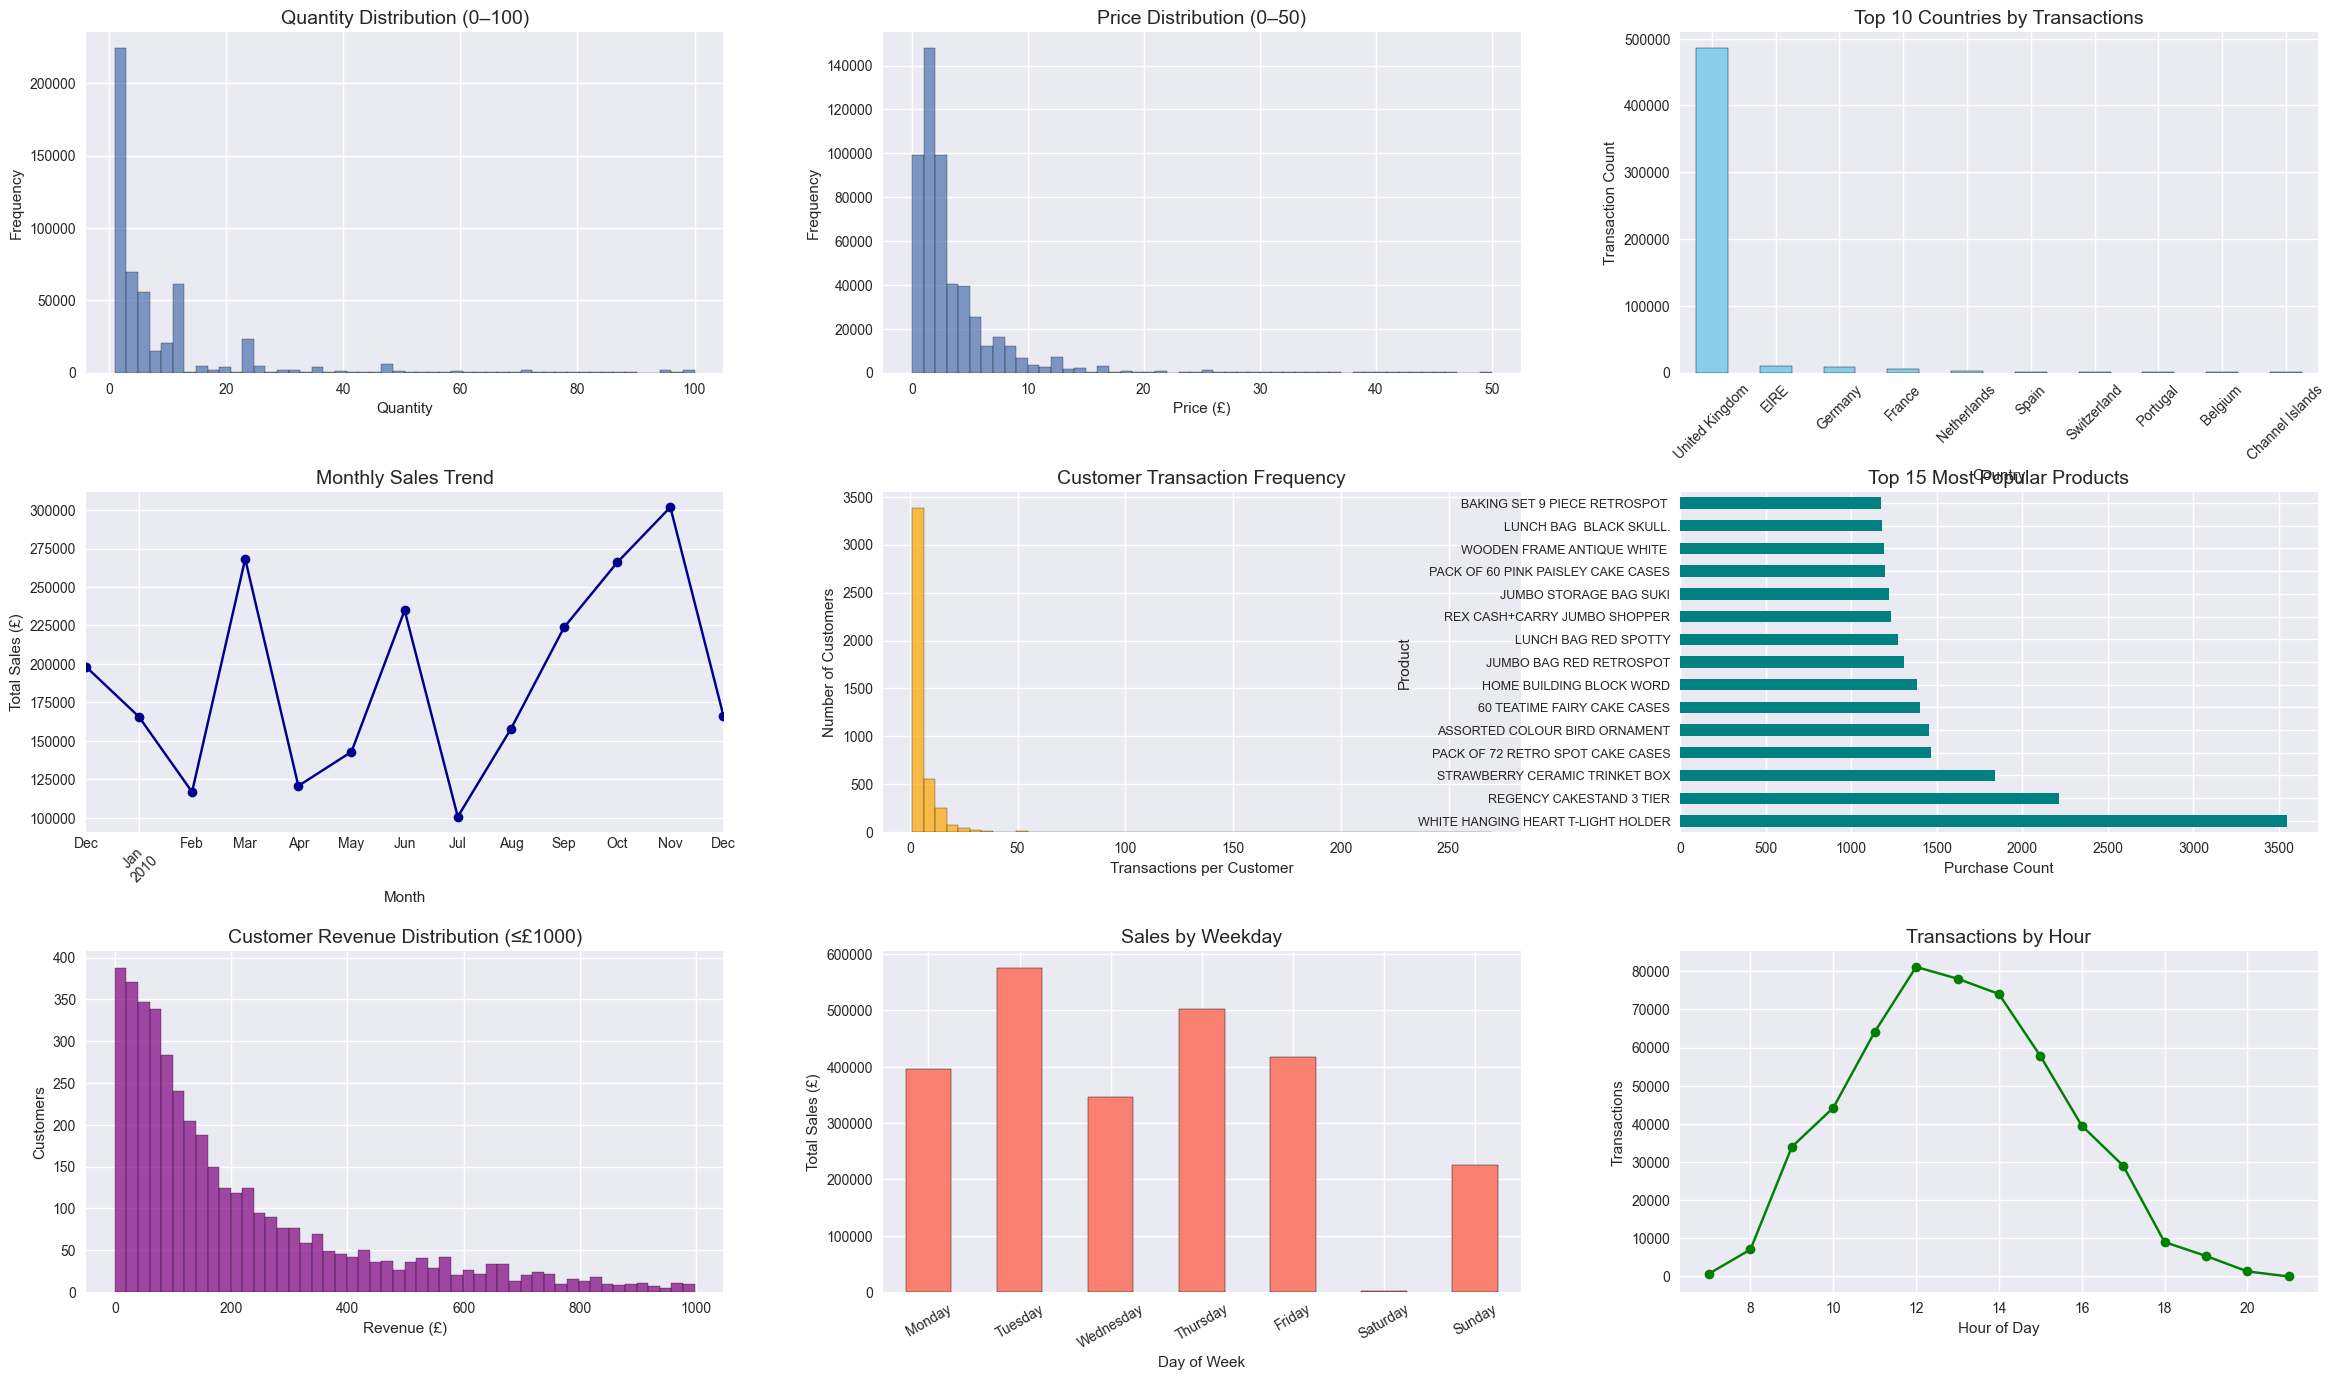

In [82]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8")
fig, axes = plt.subplots(3, 3, figsize=(24, 14))  # wider and shorter
axes = axes.flatten()

# ---  Quantity distribution ---
quantity_filtered = df[df['Quantity'].between(0, 100)]['Quantity']
axes[0].hist(quantity_filtered, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Quantity Distribution (0–100)', fontsize=14)
axes[0].set_xlabel('Quantity')
axes[0].set_ylabel('Frequency')

# ---  Price distribution ---
price_filtered = df[df['Price'].between(0, 50)]['Price']
axes[1].hist(price_filtered, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_title('Price Distribution (0–50)', fontsize=14)
axes[1].set_xlabel('Price (£)')
axes[1].set_ylabel('Frequency')

# ---  Top countries ---
top_countries = df['Country'].value_counts().head(10)
top_countries.plot(kind='bar', ax=axes[2], color="skyblue", edgecolor="black")
axes[2].set_title('Top 10 Countries by Transactions', fontsize=14)
axes[2].set_xlabel('Country')
axes[2].set_ylabel('Transaction Count')
axes[2].tick_params(axis='x', rotation=45)

# ---  Monthly sales trend ---
df['YearMonth'] = pd.to_datetime(df['InvoiceDate']).dt.to_period('M')
monthly_sales = df.groupby('YearMonth')['Price'].sum()
monthly_sales.plot(kind='line', marker='o', ax=axes[3], color="darkblue")
axes[3].set_title('Monthly Sales Trend', fontsize=14)
axes[3].set_xlabel('Month')
axes[3].set_ylabel('Total Sales (£)')
axes[3].tick_params(axis='x', rotation=45)

# ---  Customer transaction frequency ---
customer_transactions = df.groupby('Customer ID')['Invoice'].nunique()
axes[4].hist(customer_transactions, bins=50, edgecolor='black', alpha=0.7, color="orange")
axes[4].set_title('Customer Transaction Frequency', fontsize=14)
axes[4].set_xlabel('Transactions per Customer')
axes[4].set_ylabel('Number of Customers')

# ---  Top products ---
top_products = df['Description'].value_counts().head(15)
top_products.plot(kind='barh', ax=axes[5], color="teal")
axes[5].set_title('Top 15 Most Popular Products', fontsize=14)
axes[5].set_xlabel('Purchase Count')
axes[5].set_ylabel('Product')
axes[5].tick_params(axis='y', labelsize=9)  # smaller font for long names

# ---  Revenue per customer ---
customer_revenue = df.groupby('Customer ID')['Price'].sum()
axes[6].hist(customer_revenue[customer_revenue <= 1000], bins=50, edgecolor='black', alpha=0.7, color="purple")
axes[6].set_title('Customer Revenue Distribution (≤£1000)', fontsize=14)
axes[6].set_xlabel('Revenue (£)')
axes[6].set_ylabel('Customers')

# ---  Weekday analysis ---
df['Weekday'] = pd.to_datetime(df['InvoiceDate']).dt.day_name()
weekday_sales = df.groupby('Weekday')['Price'].sum()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = weekday_sales.reindex(weekday_order)
weekday_sales.plot(kind='bar', ax=axes[7], color="salmon", edgecolor="black")
axes[7].set_title('Sales by Weekday', fontsize=14)
axes[7].set_xlabel('Day of Week')
axes[7].set_ylabel('Total Sales (£)')
axes[7].tick_params(axis='x', rotation=30)

# ---  Hourly transactions ---
df['Hour'] = pd.to_datetime(df['InvoiceDate']).dt.hour
hourly_transactions = df.groupby('Hour').size()
hourly_transactions.plot(kind='line', marker='o', ax=axes[8], color="green")
axes[8].set_title('Transactions by Hour', fontsize=14)
axes[8].set_xlabel('Hour of Day')
axes[8].set_ylabel('Transactions')

plt.subplots_adjust(
    top=0.95, 
    bottom=0.05, 
    left=0.05, 
    right=0.98, 
    hspace=0.35, 
    wspace=0.25
)
plt.show()


## Data Cleaning

The dataset required thorough cleaning to ensure reliable analysis. This involved removing cancelled orders, invalid quantities and prices, missing or duplicate customer records, and incorrect dates. All columns were standardized, and the data was reindexed to create a consistent and accurate dataset for further analysis.

In [83]:
import pandas as pd

df_clean = df.copy()

# Remove cancelled invoices (InvoiceNo starting with 'C')
df_clean = df_clean[~df_clean['Invoice'].astype(str).str.startswith('C')]

# Remove negative or zero Quantity and Price
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['Price'] > 0)]

# Drop rows with missing CustomerID
df_clean = df_clean.dropna(subset=['Customer ID'])

# Drop duplicates
df_clean = df_clean.drop_duplicates()

# Ensure InvoiceDate is datetime and handle errors
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')
df_clean = df_clean.dropna(subset=['InvoiceDate'])  # Remove rows where date conversion failed
df_clean['Customer ID'] = df_clean['Customer ID'].astype('int64')


df_clean = df_clean.reset_index(drop=True)


In [84]:
print("Original shape:", df.shape)
print("Cleaned shape :", df_clean.shape)

Original shape: (525461, 11)
Cleaned shape : (400916, 11)


In [85]:
print("\n--- Missing Values After Cleaning ---")
print(df_clean.isnull().sum())



--- Missing Values After Cleaning ---
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
YearMonth      0
Weekday        0
Hour           0
dtype: int64


In [86]:
print("--- Sample Clean Data ---")
display(df_clean.head())

--- Sample Clean Data ---


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,YearMonth,Weekday,Hour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,2009-12,Tuesday,7
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12,Tuesday,7
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12,Tuesday,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,2009-12,Tuesday,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,2009-12,Tuesday,7


## Data Cleaning Summary


In [87]:
print("Data cleaning analysis:")
print(f"Original dataset: {df.shape[0]:,} rows")
print(f"After cleaning: {df_clean.shape[0]:,} rows")
print(f"Removed: {df.shape[0] - df_clean.shape[0]:,} rows ({(df.shape[0] - df_clean.shape[0])/df.shape[0]*100:.1f}%)")

print(f"\nQuality checks after cleaning:")
print(f"- Missing Customer IDs: {df_clean['Customer ID'].isnull().sum()}")
print(f"- Negative quantities: {(df_clean['Quantity'] < 0).sum()}")
print(f"- Zero/negative prices: {(df_clean['Price'] <= 0).sum()}")
print(f"- Duplicate rows: {df_clean.duplicated().sum()}")

Data cleaning analysis:
Original dataset: 525,461 rows
After cleaning: 400,916 rows
Removed: 124,545 rows (23.7%)

Quality checks after cleaning:
- Missing Customer IDs: 0
- Negative quantities: 0
- Zero/negative prices: 0
- Duplicate rows: 0


## Cleaned Data Statistics

The cleaned dataset includes 4,312 unique customers and 4,444 unique products, spanning the period from December 2009 to December 2010. Total revenue amounts to £1.33 million, with an average transaction value of £3.31.

In [88]:
print("--- CLEANED DATA CHARACTERISTICS ---")
print(f"Unique customers: {df_clean['Customer ID'].nunique():,}")
print(f"Unique products: {df_clean['Description'].nunique():,}")
print(f"Date range: {df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}")
print(f"Total revenue: {df_clean['Price'].sum():,.2f}")
print(f"Average transaction value: {df_clean['Price'].mean():.2f}")

--- CLEANED DATA CHARACTERISTICS ---
Unique customers: 4,312
Unique products: 4,444
Date range: 2009-12-01 07:45:00 to 2010-12-09 20:01:00
Total revenue: 1,325,358.59
Average transaction value: 3.31


## Customer Metrics Overview

After cleaning and removing outliers, the dataset includes 4,268 customers. The following visualization highlights the distribution of recency, frequency, and monetary metrics, with RFM for short. Skewed metrics were log-transformed to normalize their distributions, which is important for clustering methods that rely on distance measures. Recency was not log-transformed, as it does not exhibit a long-tailed distribution.

Reference date for recency: 2010-12-10 20:01:00
Before outlier removal: 4312 customers
After outlier removal: 4268 customers


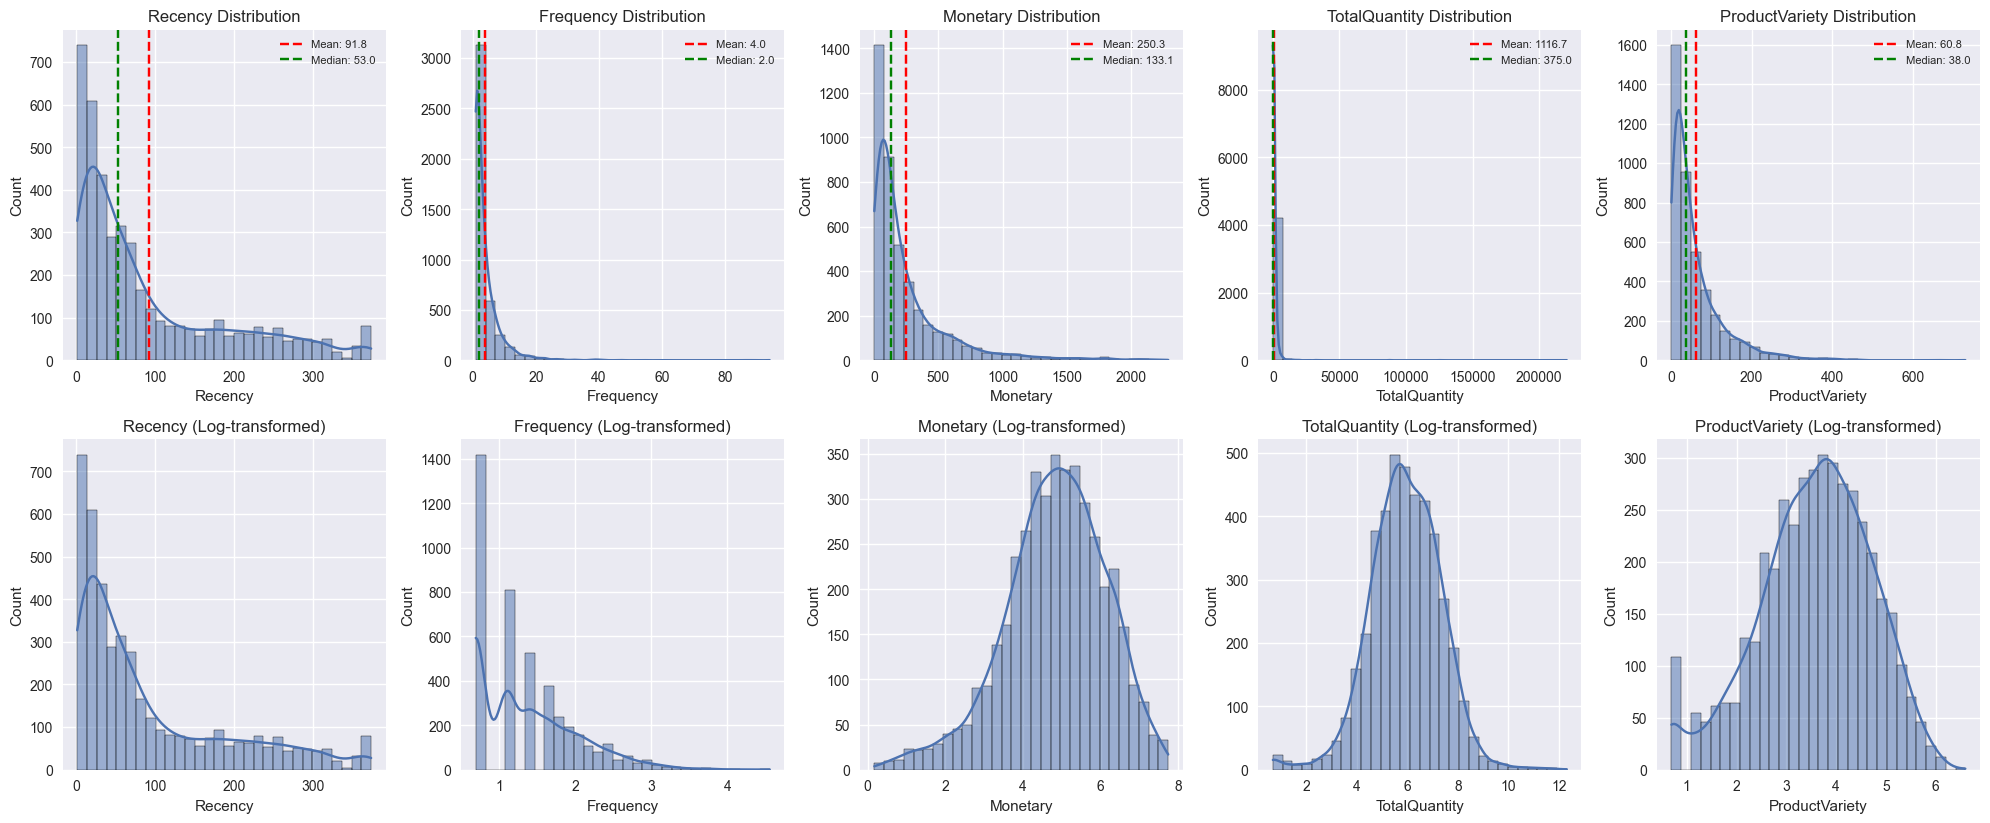

           Recency    Frequency     Monetary  TotalQuantity  ProductVariety
count  4268.000000  4268.000000  4268.000000    4268.000000     4268.000000
mean     91.750937     4.025070   250.254687    1116.684161       60.791940
std      96.985154     5.261262   319.459361    5456.648154       67.724876
min       1.000000     1.000000     0.190000       1.000000        1.000000
25%      19.000000     1.000000    56.180000     155.000000       17.000000
50%      53.000000     2.000000   133.100000     375.000000       38.000000
75%     137.000000     5.000000   309.320000     966.250000       79.000000
max     374.000000    94.000000  2290.540000  220600.000000      730.000000


In [89]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

ref_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Reference date for recency: {ref_date}")

rfm = df_clean.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency (days)
    'Invoice': 'nunique',                                # Frequency (unique invoices)
    'Price': 'sum'                                       # Monetary (total spent)
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

customer_metrics = df_clean.groupby('Customer ID').agg({
    'Quantity': ['sum', 'mean'],                         # Total and average quantity
    'Description': 'nunique',                            # Product variety
    'InvoiceDate': lambda x: (x.max() - x.min()).days   # Customer lifetime span
}).reset_index()

customer_metrics.columns = ['CustomerID', 'TotalQuantity', 'AvgQuantity', 'ProductVariety', 'LifetimeSpan']
rfm = rfm.merge(customer_metrics, on='CustomerID')

print(f"Before outlier removal: {len(rfm)} customers")
rfm = rfm[(rfm['Monetary'] > 0) & (rfm['Frequency'] > 0)]
rfm = rfm[rfm['Monetary'] <= rfm['Monetary'].quantile(0.99)]  # Remove top 1% to reduce skewness
print(f"After outlier removal: {len(rfm)} customers")

plt.figure(figsize=(20, 12))

for i, col in enumerate(['Recency', 'Frequency', 'Monetary', 'TotalQuantity', 'ProductVariety']):
    plt.subplot(3, 5, i+1)
    sns.histplot(rfm[col], kde=True, bins=30)
    plt.title(f'{col} Distribution')
    
    # Add statistical annotations
    mean_val = rfm[col].mean()
    median_val = rfm[col].median()
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f}')
    plt.axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.1f}')
    plt.legend(fontsize=8)

rfm_log = rfm.copy()
for col in ['Frequency', 'Monetary', 'TotalQuantity', 'ProductVariety']:
    rfm_log[col] = np.log1p(rfm_log[col])

# Log-transformed distributions
for i, col in enumerate(['Recency', 'Frequency', 'Monetary', 'TotalQuantity', 'ProductVariety']):
    plt.subplot(3, 5, i+6)
    sns.histplot(rfm_log[col], kde=True, bins=30)
    plt.title(f'{col} (Log-transformed)')

plt.tight_layout()
plt.show()

print(rfm[['Recency', 'Frequency', 'Monetary', 'TotalQuantity', 'ProductVariety']].describe())


## RFM Feature Correlation Analysis

The correlation analysis of RFM features reveals several notable patterns in customer behavior. There is a strong positive correlation between monetary value and product variety (r = 0.88), indicating that customers who spend more also tend to purchase a wider range of products. Frequency and monetary value are moderately correlated (r = 0.66), suggesting that customers who make purchases more often also tend to spend more overall. Additionally, frequency and product variety show a positive correlation (r = 0.55), meaning that frequent buyers are more likely to explore and purchase from a broader selection of products. These insights highlight the relationships between how often customers buy, how much they spend, and the diversity of their purchases.

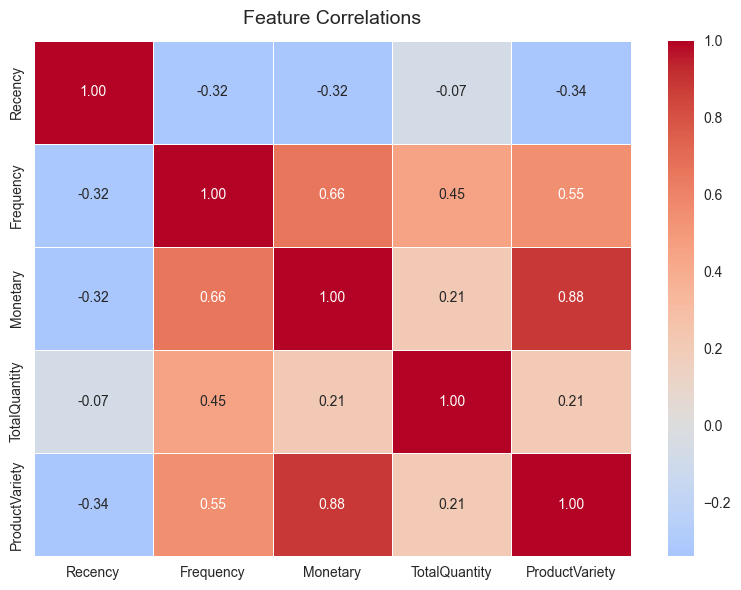

In [90]:

correlation_matrix = rfm[['Recency', 'Frequency', 'Monetary', 'TotalQuantity', 'ProductVariety']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    center=0, 
    fmt='.2f',
    linewidths=0.5,
    cbar=True
)
plt.title('Feature Correlations', fontsize=14, pad=12)
plt.tight_layout()
plt.show()


## PC Analysis
Reducing the RFM features to 2 dimensions using PCA serves a few important purposes. First, it simplifies the data while retaining most of the original variability, making it easier to visualize and interpret customer patterns. Working in a lower-dimensional space also removes correlations between features, which helps clustering algorithms like K-Means perform more effectively because they rely on distance measures. Finally, reducing to two dimensions allows us to plot the customers on a 2D scatter, providing an intuitive view of the clusters and helping validate the quality of the segmentation visually. Overall, PCA makes the clustering process faster, more robust, and easier to interpret without losing key information.

Explained variance by each component: [0.67647707 0.21936823]
Total variance explained by 2 components: 0.90

PCA Composition Table:


,Recency,Frequency,Monetary
PCA1,-0.503,0.621,0.601
PCA2,0.857,0.266,0.441


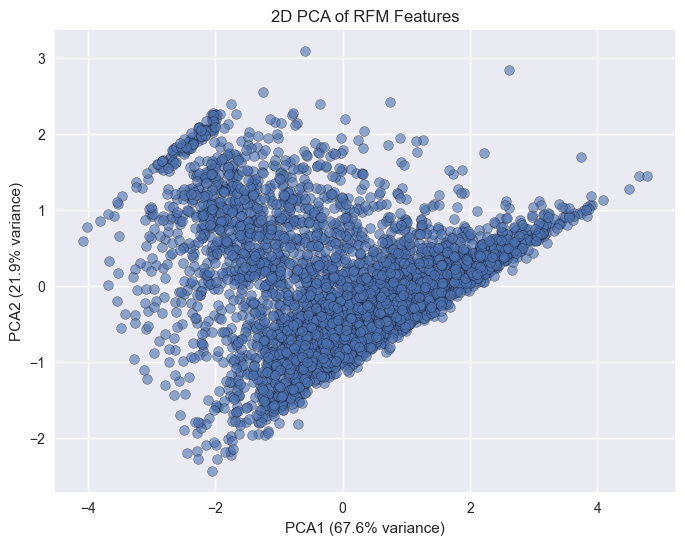

In [91]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

feature_cols = ['Recency', 'Frequency', 'Monetary']
X = rfm_log[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
rfm['PCA1'] = X_pca[:, 0]
rfm['PCA2'] = X_pca[:, 1]

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each component: {explained_variance}")
print(f"Total variance explained by 2 components: {explained_variance.sum():.2f}")

pca_components = pd.DataFrame(
    pca.components_,
    columns=feature_cols,
    index=['PCA1', 'PCA2']
)
pca_components = pca_components.round(3) 

print("\nPCA Composition Table:")
display(pca_components)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, edgecolor='k')
plt.xlabel(f'PCA1 ({explained_variance[0]*100:.1f}% variance)')
plt.ylabel(f'PCA2 ({explained_variance[1]*100:.1f}% variance)')
plt.title('2D PCA of RFM Features')
plt.grid(True)
plt.show()



# K-Means Clustering for Customers segmentation

K-Means clustering was applied to the scaled RFM features, with the number of clusters (k) varied from 2 to 10 in a parameter sweep. The clustering results were evaluated using Inertia, Silhouette Score, and Davies-Bouldin Index to assess cluster compactness and separation. Based on these metrics, 3 clusters were identified as the optimal choice, providing a good balance between cohesion within clusters and separation between clusters. Visualizations of the clusters further confirm the quality of this segmentation and support the selection of the optimal

k=2: Inertia=5692.68, Silhouette=0.434, Davies-Bouldin=0.865
k=3: Inertia=3366.69, Silhouette=0.455, Davies-Bouldin=0.764
k=4: Inertia=2441.10, Silhouette=0.417, Davies-Bouldin=0.761
k=5: Inertia=2019.08, Silhouette=0.414, Davies-Bouldin=0.818
k=6: Inertia=1663.51, Silhouette=0.377, Davies-Bouldin=0.847
k=7: Inertia=1443.62, Silhouette=0.380, Davies-Bouldin=0.834
k=8: Inertia=1264.93, Silhouette=0.364, Davies-Bouldin=0.868
k=9: Inertia=1124.27, Silhouette=0.372, Davies-Bouldin=0.819
k=10: Inertia=1002.91, Silhouette=0.364, Davies-Bouldin=0.840

Optimal number of clusters: 3


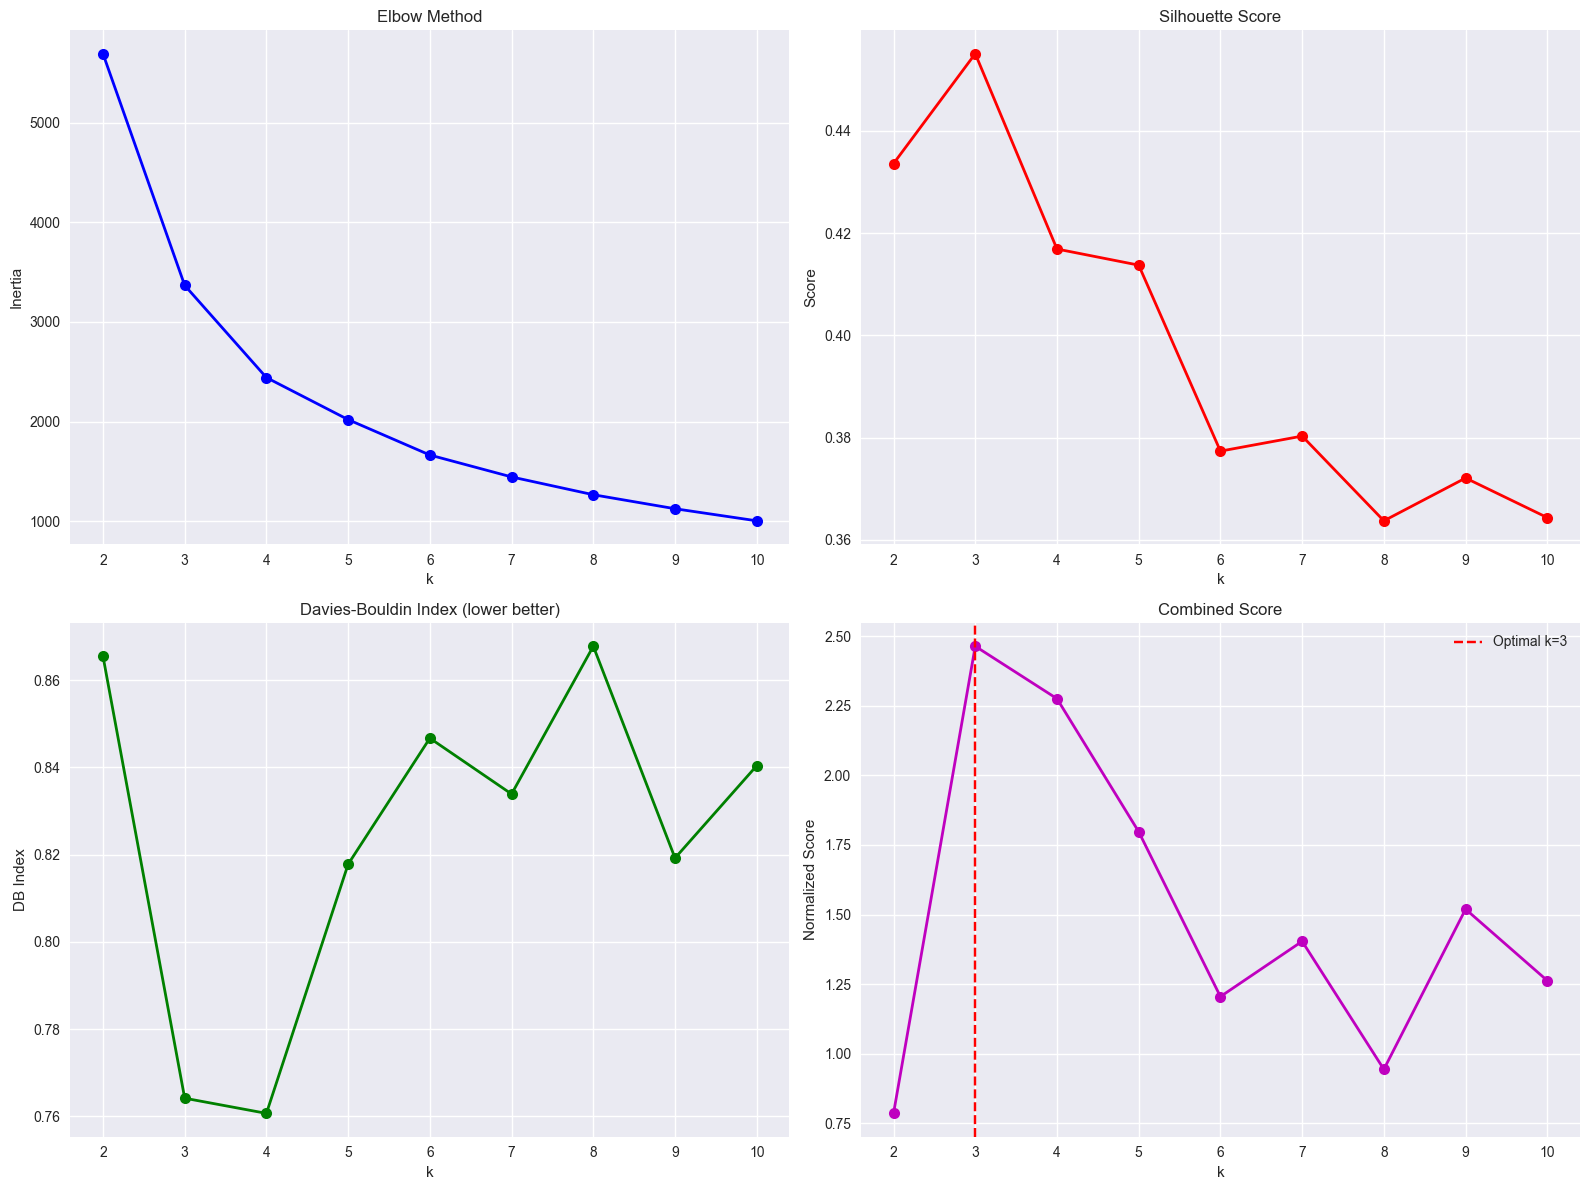

In [92]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# --- K-Means clustering hyperparameter sweeping---
inertia, silhouette, davies_bouldin = [], [], []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=300)
    labels = kmeans.fit_predict(X_pca)
    
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_pca, labels))
    davies_bouldin.append(davies_bouldin_score(X_pca, labels))
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, "
          f"Silhouette={silhouette_score(X_pca, labels):.3f}, "
          f"Davies-Bouldin={davies_bouldin_score(X_pca, labels):.3f}")

norm_inertia = [(max(inertia)-i)/(max(inertia)-min(inertia)) for i in inertia]
norm_silhouette = [(s - min(silhouette))/(max(silhouette)-min(silhouette)) for s in silhouette]
norm_db = [(max(davies_bouldin)-db)/(max(davies_bouldin)-min(davies_bouldin)) for db in davies_bouldin]
combined_score = [sum(x) for x in zip(norm_inertia, norm_silhouette, norm_db)]
optimal_k = K[combined_score.index(max(combined_score))]
print(f"\nOptimal number of clusters: {optimal_k}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(K, inertia, 'bo-', markersize=8, linewidth=2)
axes[0, 0].set_title("Elbow Method")
axes[0, 0].set_xlabel("k")
axes[0, 0].set_ylabel("Inertia")

axes[0, 1].plot(K, silhouette, 'ro-', markersize=8, linewidth=2)
axes[0, 1].set_title("Silhouette Score")
axes[0, 1].set_xlabel("k")
axes[0, 1].set_ylabel("Score")

axes[1, 0].plot(K, davies_bouldin, 'go-', markersize=8, linewidth=2)
axes[1, 0].set_title("Davies-Bouldin Index (lower better)")
axes[1, 0].set_xlabel("k")
axes[1, 0].set_ylabel("DB Index")

axes[1, 1].plot(K, combined_score, 'mo-', markersize=8, linewidth=2)
axes[1, 1].axvline(optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
axes[1, 1].set_title("Combined Score")
axes[1, 1].set_xlabel("k")
axes[1, 1].set_ylabel("Normalized Score")
axes[1, 1].legend()

plt.tight_layout()
plt.show()


# Final K-Means Clustering (k=3)

The final K-Means clustering model (k=3) produced a silhouette score of 0.390, indicating moderate cluster separation. The clusters are distributed fairly evenly.

Cluster 0 represents customers with high recency but low frequency and spending, suggesting recent but low-value engagement. Cluster 1 includes highly active and valuable customers, with high frequency, monetary value, and product variety, reflecting loyal and engaged buyers. Cluster 2 captures customers with moderate recency, low to moderate frequency, and spending, representing occasional or moderately engaged customers. These clusters provide insights into customer behavior, helping guide targeted marketing and retention strategies.


In [93]:
k_final = 3
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=20, max_iter=300, algorithm='lloyd')
rfm['Cluster'] = kmeans_final.fit_predict(X_pca)

final_silhouette = silhouette_score(X_scaled, rfm['Cluster'])
print(f"Final K-means model performance:")
print(f"- Silhouette score: {final_silhouette:.3f}")

cluster_counts = rfm['Cluster'].value_counts().sort_index()
print("Cluster distribution:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count:,} customers ({count/len(rfm)*100:.1f}%)")

cluster_profiles = rfm.groupby('Cluster')[['Recency','Frequency','Monetary','TotalQuantity','ProductVariety','LifetimeSpan']].agg(['mean','median','std']).round(2)
display(cluster_profiles)



Final K-means model performance:
- Silhouette score: 0.390
Cluster distribution:
Cluster 0: 932 customers (21.8%)
Cluster 1: 1,569 customers (36.8%)
Cluster 2: 1,767 customers (41.4%)


Recency               Frequency              Monetary                  \
           mean median    std      mean median   std     mean  median     std   
Cluster                                                                         
0        252.68  246.0  62.90      1.44    1.0  0.86    85.73   59.94   97.73   
1         36.04   22.0  39.63      7.93    6.0  7.03   521.33  401.80  386.68   
2         56.34   49.0  39.59      1.92    2.0  1.05    96.33   79.75   74.29   

        TotalQuantity                  ProductVariety                \
                 mean  median      std           mean median    std   
Cluster                                                               
0              505.89   146.0  7250.41          23.72   18.0  23.99   
1             2187.36  1126.0  6262.13         117.44   96.0  80.15   
2              488.14   250.0  2793.01          30.04   25.0  23.50   

        LifetimeSpan                 
                mean median     std  
Cluster                              
0              20.94    0.0   43.80  
1             252.00  267.0   95.98  
2              84.57   21.0  106.16

# Final K-Means Cluster Visualization 


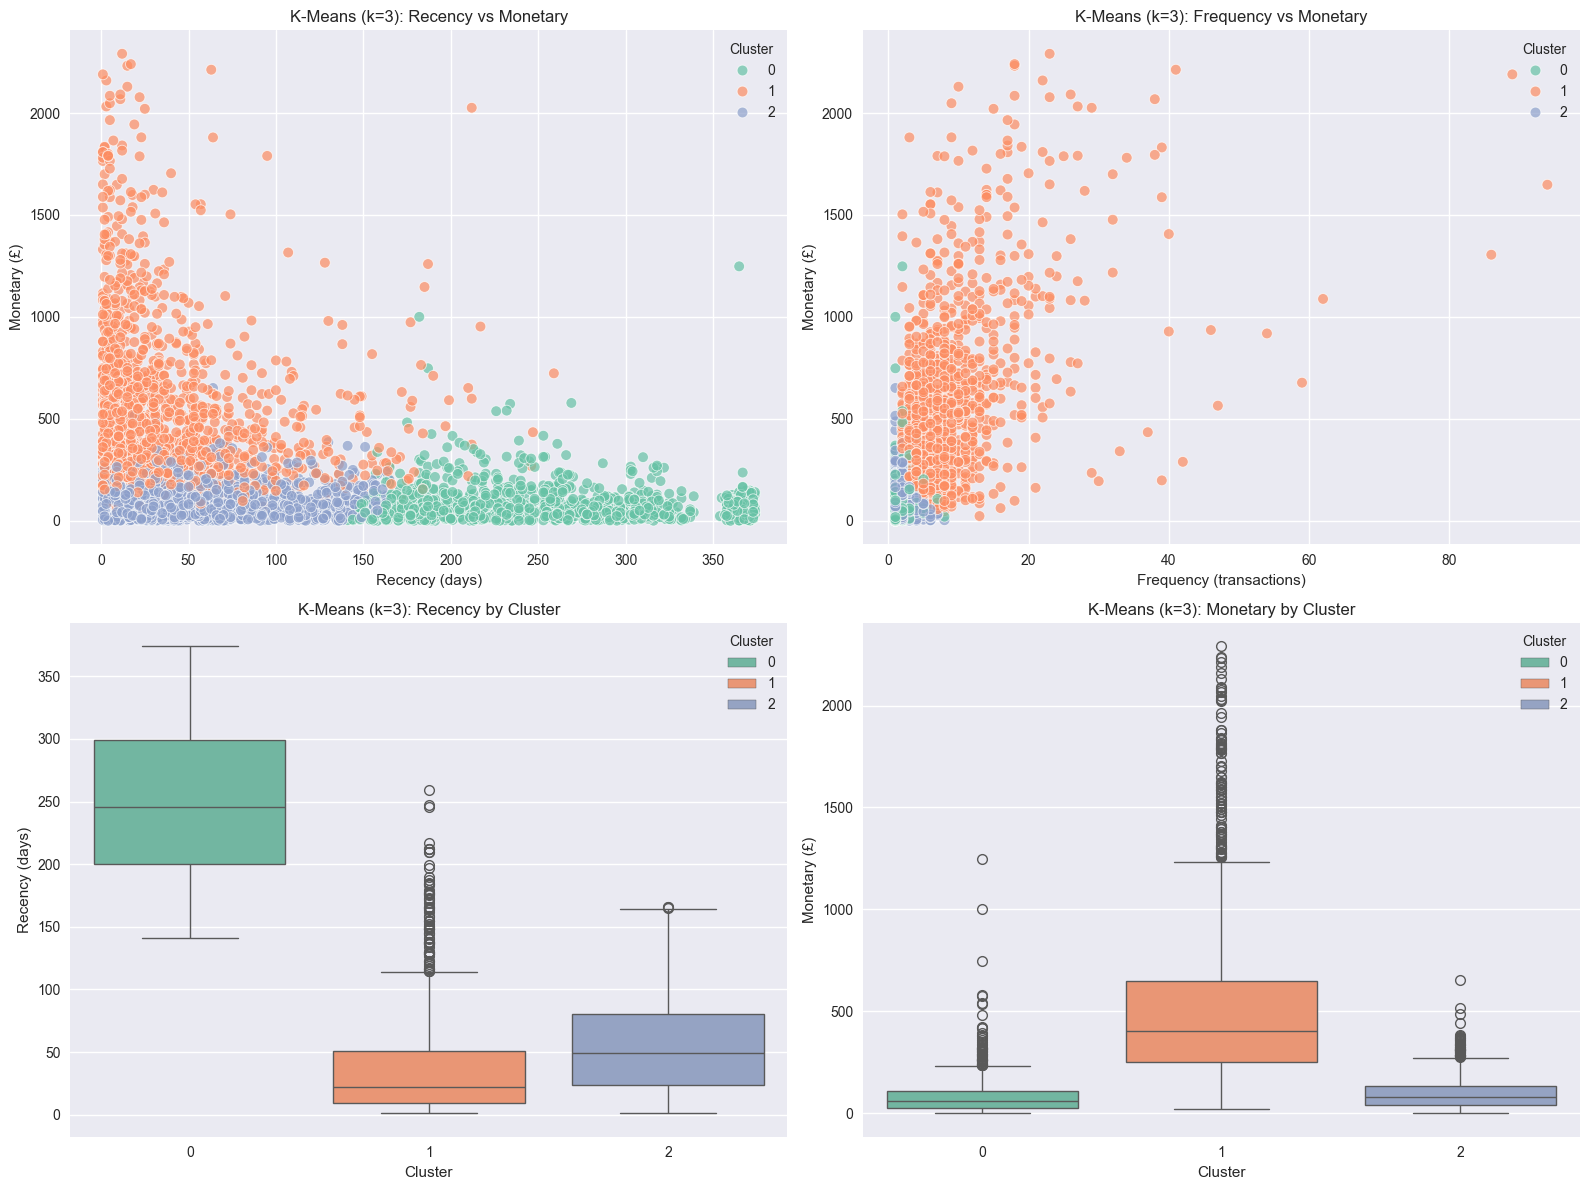

In [94]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', palette='Set2', data=rfm, ax=axes[0, 0], s=60, alpha=0.7)
axes[0, 0].set_title("K-Means (k=3): Recency vs Monetary")
axes[0, 0].set_xlabel("Recency (days)")
axes[0, 0].set_ylabel("Monetary (£)")

sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', palette='Set2', data=rfm, ax=axes[0, 1], s=60, alpha=0.7)
axes[0, 1].set_title("K-Means (k=3): Frequency vs Monetary")
axes[0, 1].set_xlabel("Frequency (transactions)")
axes[0, 1].set_ylabel("Monetary (£)")

rfm_melted = pd.melt(rfm[['Cluster','Recency','Frequency','Monetary']], id_vars=['Cluster'], var_name='RFM_Dimension', value_name='Value')
sns.boxplot(data=rfm_melted[rfm_melted['RFM_Dimension']=='Recency'], x='Cluster', y='Value', ax=axes[1, 0], palette='Set2', hue='Cluster')
axes[1, 0].set_title("K-Means (k=3): Recency by Cluster")
axes[1, 0].set_ylabel("Recency (days)")

sns.boxplot(data=rfm_melted[rfm_melted['RFM_Dimension']=='Monetary'], x='Cluster', y='Value', ax=axes[1, 1], palette='Set2', hue='Cluster')
axes[1, 1].set_title("K-Means (k=3): Monetary by Cluster")
axes[1, 1].set_ylabel("Monetary (£)")

plt.tight_layout()
plt.show()


# K-Means Clustering Visualization with centroid (k=3) 


| Cluster | Recency       | Frequency      | Monetary Value | Product Variety | Description                              |
|---------|---------------|----------------|----------------|----------------|------------------------------------------|
| 0       | High          | Low            | Low            | Low            | low-value customers           |
| 1       | Medium/Low    | High           | High           | High           | Loyal and highly engaged customers       |
| 2       | Moderate      | Low to Moderate| Low to Moderate| Moderate       | moderately engaged customers|



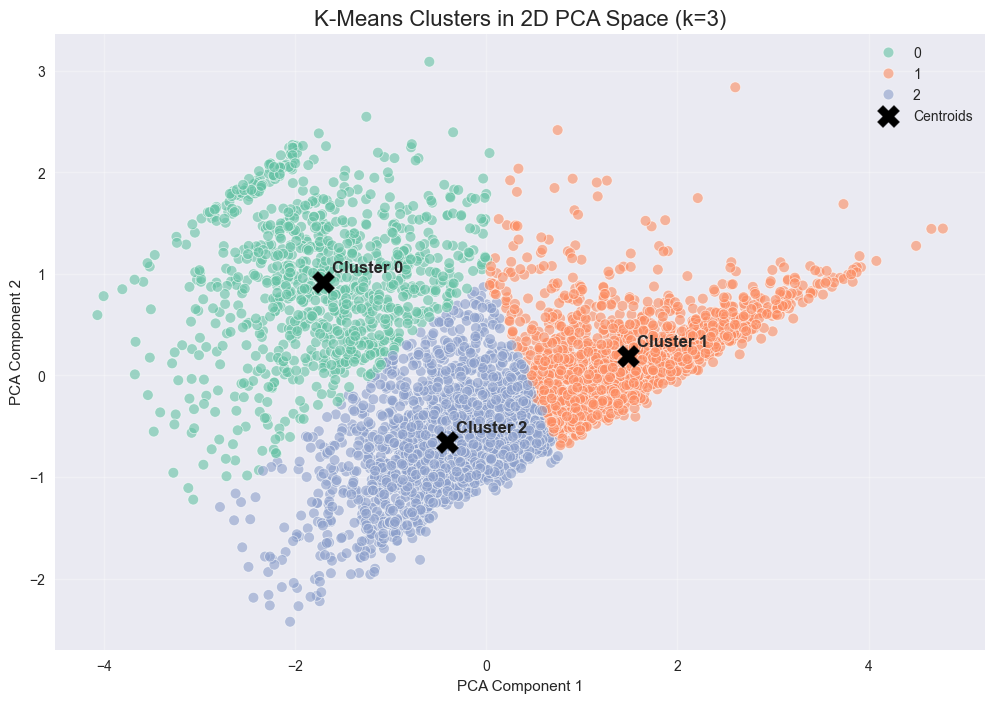

In [95]:

centroids_pca = kmeans_final.cluster_centers_

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=rfm, x='PCA1', y='PCA2',
    hue='Cluster', palette='Set2',
    s=60, alpha=0.6
)

plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    c='black', marker='X', s=250, label='Centroids'
)

for i, (x, y) in enumerate(centroids_pca):
    plt.text(x + 0.1, y + 0.1, f'Cluster {i}', fontsize=12, weight='bold')

plt.title(f'K-Means Clusters in 2D PCA Space (k={optimal_k})', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Agglomerative Clustering for customer segmentation

Agglomerative clustering was applied to PCA-reduced RFM features (2 components) for 4,268 customers, testing 3–7 clusters with ward, complete, average, and single linkages. The best result was 3 clusters with Ward linkage, achieving a silhouette score of around 0.41. Ward linkage produced compact, well-separated clusters, and the silhouette decline with more clusters indicates potential over-segmentation. Selecting 3 clusters aligns with standard RFM segmentation (High, Medium, Low value), balancing statistical separation and business interpretability.


In [96]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


n_clusters_range = range(3, 8)
linkage_methods = ['ward', 'complete', 'average', 'single']

results = []

for n_clusters in n_clusters_range:
    for linkage_method in linkage_methods:
        metric = 'euclidean' if linkage_method == 'ward' else 'manhattan'
        
        agglo = AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage=linkage_method,
            metric=metric
        )
        labels = agglo.fit_predict(X_pca)
        
        sil = silhouette_score(X_pca, labels)
        results.append({
            'n_clusters': n_clusters,
            'linkage': linkage_method,
            'silhouette': sil
        })
        print(f"Clusters={n_clusters}, Linkage={linkage_method} -> Silhouette={sil:.3f}")

results_df = pd.DataFrame(results)

best_idx = results_df['silhouette'].idxmax()
best_config = results_df.loc[best_idx]
print("\nBest Agglomerative Clustering configuration:")
print(best_config)


Clusters=3, Linkage=ward -> Silhouette=0.410
Clusters=3, Linkage=complete -> Silhouette=0.217
Clusters=3, Linkage=average -> Silhouette=0.223
Clusters=3, Linkage=single -> Silhouette=0.332
Clusters=4, Linkage=ward -> Silhouette=0.373
Clusters=4, Linkage=complete -> Silhouette=0.385
Clusters=4, Linkage=average -> Silhouette=0.313
Clusters=4, Linkage=single -> Silhouette=0.303
Clusters=5, Linkage=ward -> Silhouette=0.364
Clusters=5, Linkage=complete -> Silhouette=0.377
Clusters=5, Linkage=average -> Silhouette=0.287
Clusters=5, Linkage=single -> Silhouette=0.234
Clusters=6, Linkage=ward -> Silhouette=0.338
Clusters=6, Linkage=complete -> Silhouette=0.346
Clusters=6, Linkage=average -> Silhouette=0.365
Clusters=6, Linkage=single -> Silhouette=0.236
Clusters=7, Linkage=ward -> Silhouette=0.332
Clusters=7, Linkage=complete -> Silhouette=0.298
Clusters=7, Linkage=average -> Silhouette=0.357
Clusters=7, Linkage=single -> Silhouette=0.179

Best Agglomerative Clustering configuration:
n_cluster

# Agglomerative Clustering visualziation

Agglomerative clustering on PCA-reduced RFM features produced 3 clusters using Ward linkage: Cluster 0 with 2,086 customers (48.9%), Cluster 1 with 1,097 (25.7%), and Cluster 2 with 1,085 (25.4%), achieving a silhouette score of 0.41. Ward linkage generated compact, well-separated clusters, with reasonably balanced sizes that align with typical RFM segmentation (High, Medium, Low value). The silhouette score slightly outperformed K-Means (0.39), highlighting differences between hierarchical and centroid-based approaches.

Agglomerative clustering with 3 clusters completed
  Cluster 0: 2,086 customers (48.9%)
  Cluster 1: 1,097 customers (25.7%)
  Cluster 2: 1,085 customers (25.4%)

Agglomerative clustering performance:
- Silhouette score: 0.410

Cluster Profile Summary:


Recency               Frequency              Monetary          \
                 mean median    std      mean median   std     mean  median   
Agglo_Cluster                                                                 
0               48.36   42.0  36.16      2.36    2.0  1.41   127.55  103.92   
1               32.54   19.0  36.80      9.61    7.0  7.78   634.43  532.94   
2              235.04  231.0  73.63      1.57    1.0  1.01    97.74   64.75   

                      TotalQuantity                  ProductVariety         \
                  std          mean  median      std           mean median   
Agglo_Cluster                                                                
0              102.01        585.56   305.0  2733.98          37.94   31.0   
1              406.35       2732.37  1458.0  7312.16         138.41  118.0   
2              114.61        504.26   159.0  6723.71          26.25   19.0   

                     LifetimeSpan                 
                 std         mean median     std  
Agglo_Cluster                                     
0              30.24       111.97   69.5  117.11  
1              84.98       272.57  293.0   87.65  
2              26.42        29.27    0.0   54.50

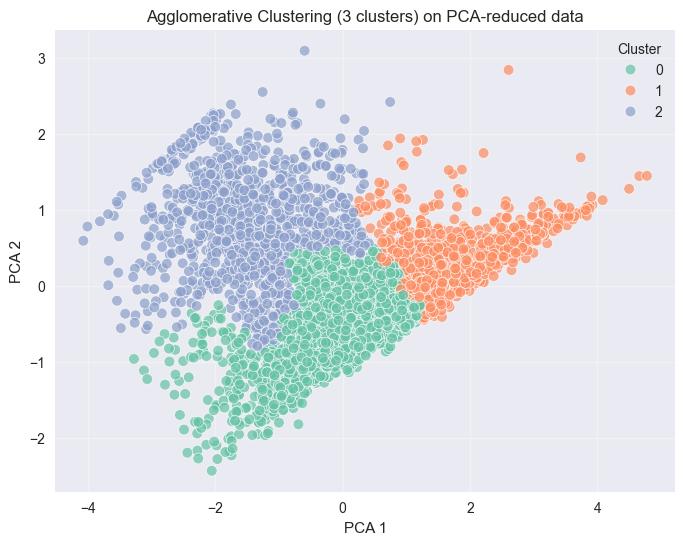

In [97]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

n_clusters = 3
linkage_method = "ward"

agglo = AgglomerativeClustering(
    n_clusters=n_clusters, 
    linkage=linkage_method, 
    metric='euclidean'
)
rfm['Agglo_Cluster'] = agglo.fit_predict(X_pca)

print(f"Agglomerative clustering with {n_clusters} clusters completed")
agglo_counts = rfm['Agglo_Cluster'].value_counts().sort_index()
for cluster, count in agglo_counts.items():
    percentage = count / len(rfm) * 100
    print(f"  Cluster {cluster}: {count:,} customers ({percentage:.1f}%)")

agglo_silhouette = silhouette_score(X_pca, rfm['Agglo_Cluster'])
agglo_db = davies_bouldin_score(X_pca, rfm['Agglo_Cluster'])
nmi = normalized_mutual_info_score(rfm['Cluster'], rfm['Agglo_Cluster'])

print(f"\nAgglomerative clustering performance:")
print(f"- Silhouette score: {agglo_silhouette:.3f}")


# --- Cluster Profile Summary ---
cluster_profiles = (
    rfm.groupby('Agglo_Cluster')[['Recency', 'Frequency', 'Monetary', 'TotalQuantity', 'ProductVariety', 'LifetimeSpan']]
    .agg(['mean', 'median', 'std'])
    .round(2)
)

print("\nCluster Profile Summary:")
display(cluster_profiles)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=rfm['Agglo_Cluster'], palette='Set2', s=60, alpha=0.7)
plt.title(f"Agglomerative Clustering ({n_clusters} clusters) on PCA-reduced data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.grid(alpha=0.3)
plt.show()


# Visualizing Agglomerative Clustering Results

The plots show the distribution of Recency, Frequency, and Monetary values across the 3 agglomerative clusters. Scatterplots highlight how clusters separate in key RFM dimensions, while boxplots reveal cluster-specific distributions and central tendencies for Recency and Monetary value.


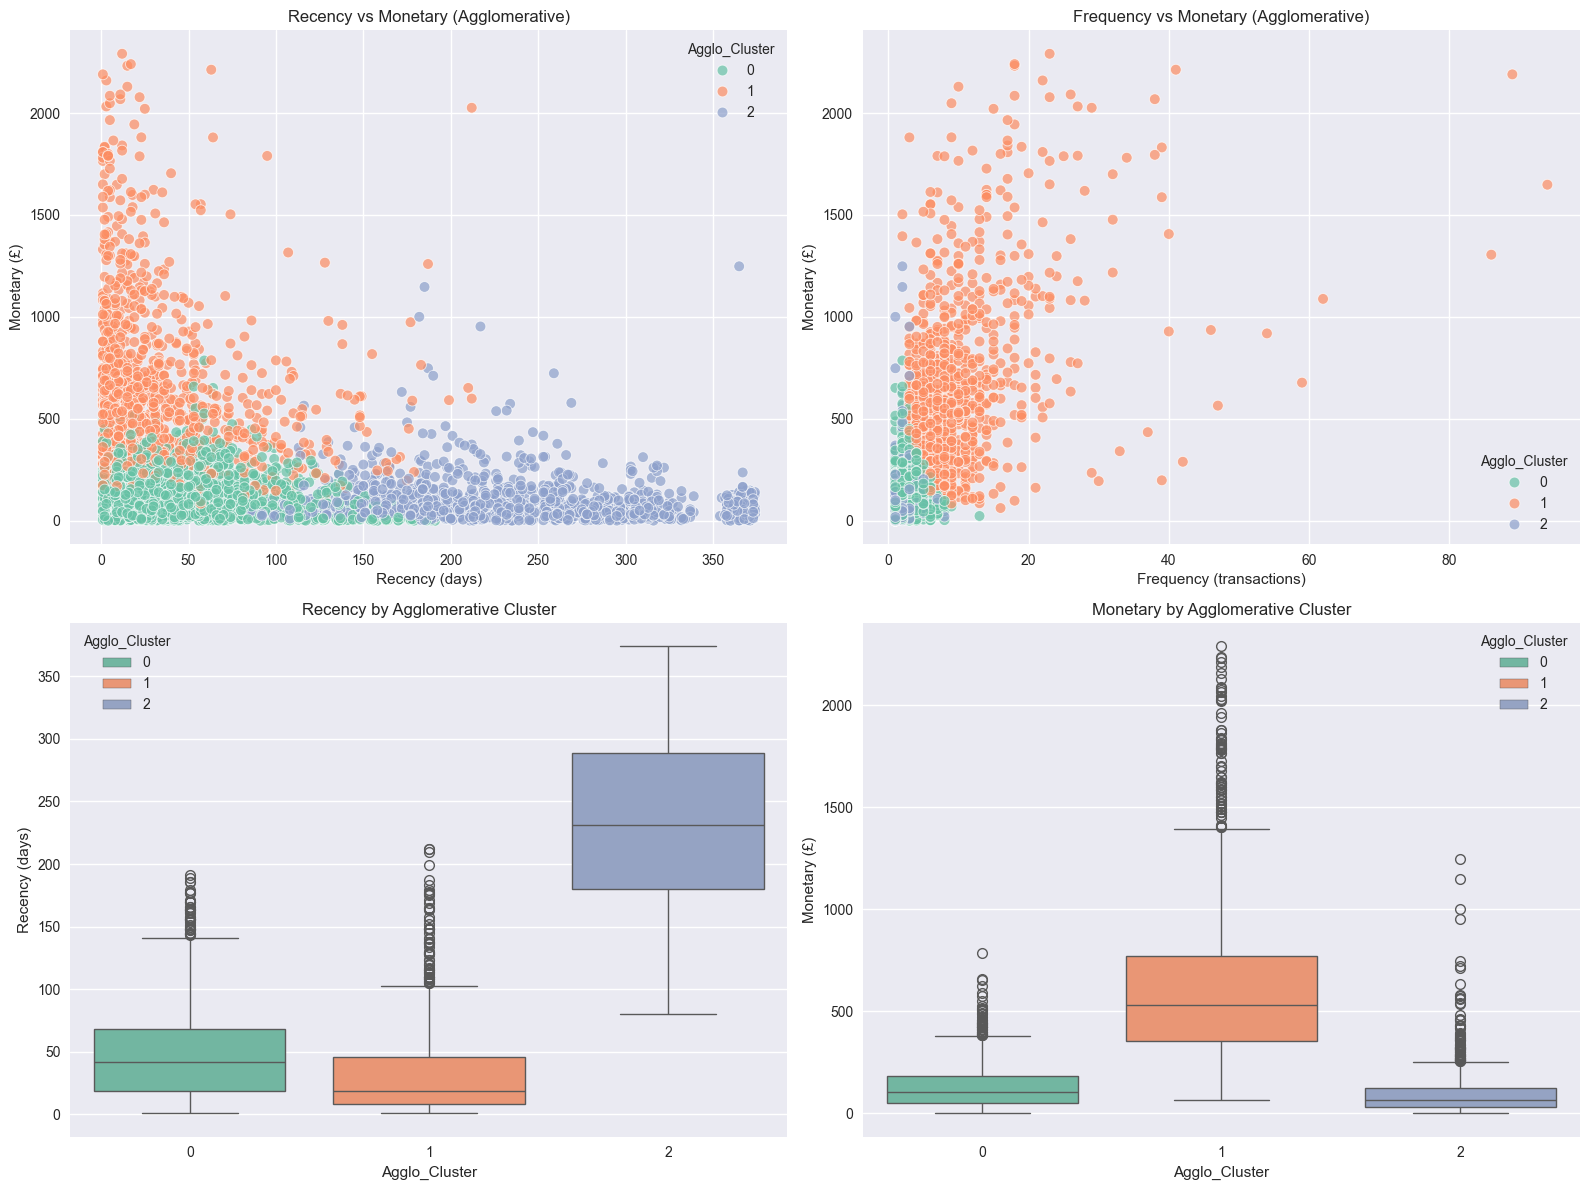

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sample_data = X_scaled if len(rfm) <= 1000 else X_scaled[np.random.choice(len(rfm), 1000, replace=False)]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.scatterplot(
    x='Recency', y='Monetary', hue='Agglo_Cluster', palette='Set2', 
    data=rfm, ax=axes[0, 0], s=60, alpha=0.7
)
axes[0, 0].set_title("Recency vs Monetary (Agglomerative)")
axes[0, 0].set_xlabel("Recency (days)")
axes[0, 0].set_ylabel("Monetary (£)")

sns.scatterplot(
    x='Frequency', y='Monetary', hue='Agglo_Cluster', palette='Set2', 
    data=rfm, ax=axes[0, 1], s=60, alpha=0.7
)
axes[0, 1].set_title("Frequency vs Monetary (Agglomerative)")
axes[0, 1].set_xlabel("Frequency (transactions)")
axes[0, 1].set_ylabel("Monetary (£)")

rfm_melted = pd.melt(
    rfm[['Agglo_Cluster','Recency','Frequency','Monetary']], 
    id_vars=['Agglo_Cluster'], var_name='RFM_Dimension', value_name='Value'
)
sns.boxplot(
    data=rfm_melted[rfm_melted['RFM_Dimension']=='Recency'], 
    x='Agglo_Cluster', y='Value', ax=axes[1, 0], palette='Set2', hue='Agglo_Cluster'
)
axes[1, 0].set_title("Recency by Agglomerative Cluster")
axes[1, 0].set_ylabel("Recency (days)")

sns.boxplot(
    data=rfm_melted[rfm_melted['RFM_Dimension']=='Monetary'], 
    x='Agglo_Cluster', y='Value', ax=axes[1, 1], palette='Set2', hue='Agglo_Cluster'
)
axes[1, 1].set_title("Monetary by Agglomerative Cluster")
axes[1, 1].set_ylabel("Monetary (£)")

plt.tight_layout()
plt.show()



# K-Means vs Agglomerative Clustering: Summary & Comparison

K-Means and Agglomerative clustering both produced three meaningful customer segments. The silhouette score for Agglomerative clustering (0.410) was slightly higher than for K-Means (0.390), indicating better cluster cohesion. Based on mean RFM values, the clusters can be described as follows:

- High-value customers: low Recency, high Frequency and Monetary 
- Medium-value customers: moderate Recency and Monetary 
- Low-value customers: high Recency, low Frequency and Monetary

K-Means is fast and works well for compact, well-separated clusters because it assumes spherical shapes. Agglomerative clustering does not assume specific cluster shapes and shows hierarchical relationships between customers, giving more insight into nested or irregular patterns. Overall, both methods identify similar customer patterns and can be used for targeted marketing: keeping high-value customers, re-engaging medium-value customers, and trying to revive low-value customers. Agglomerative clustering provides slightly better separation and more structural insight.





- K-Means Silhouette: 0.390
- Agglomerative Silhouette: 0.410
K-Means Cluster Profiles (mean RFM values):
         Recency  Frequency  Monetary
Cluster                              
0         252.68       1.44     85.73
1          36.04       7.93    521.33
2          56.34       1.92     96.33

Agglomerative Cluster Profiles (mean RFM values):
               Recency  Frequency  Monetary
Agglo_Cluster                              
0                48.36       2.36    127.55
1                32.54       9.61    634.43
2               235.04       1.57     97.74


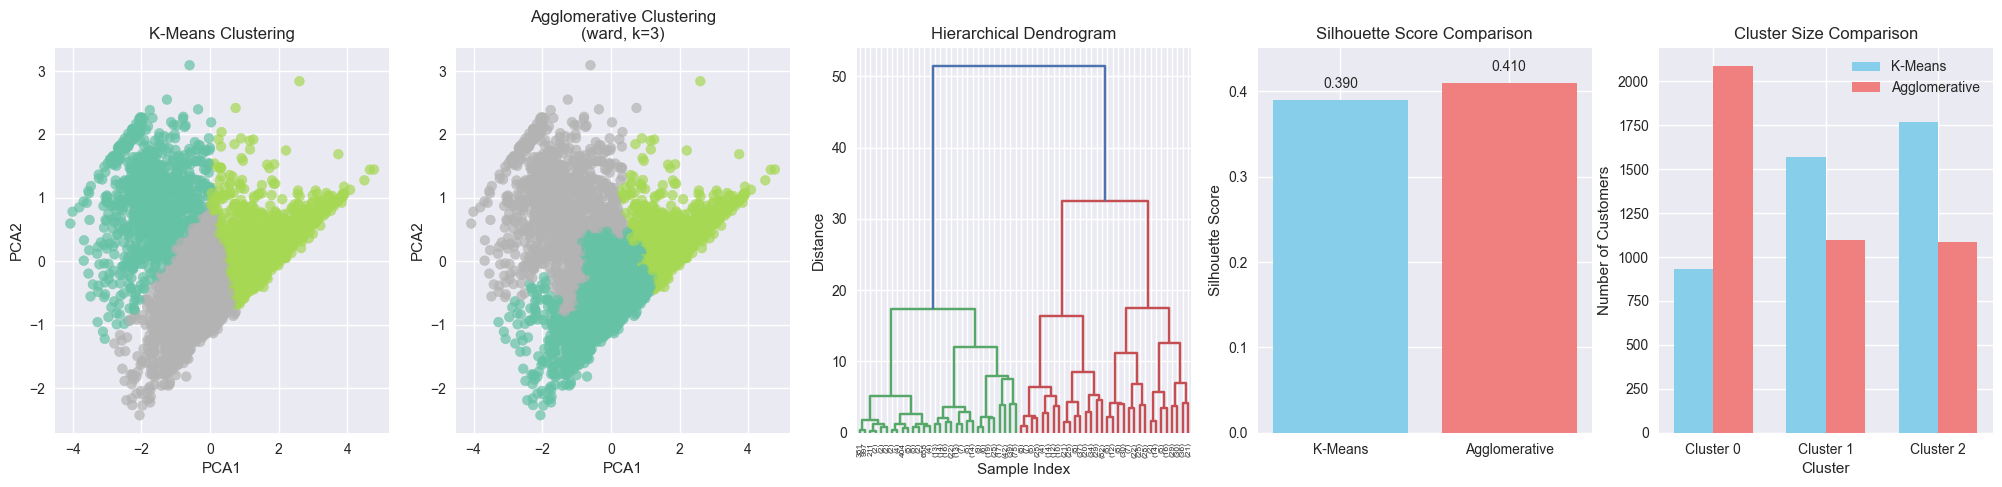

In [99]:
from scipy.cluster.hierarchy import dendrogram, linkage


print(f"- K-Means Silhouette: {final_silhouette:.3f}")
print(f"- Agglomerative Silhouette: {agglo_silhouette:.3f}")

# --- K-Means cluster profiles ---
kmeans_profiles = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().round(2)
print("K-Means Cluster Profiles (mean RFM values):")
print(kmeans_profiles)

# --- Agglomerative cluster profiles ---
agglo_profiles = rfm.groupby('Agglo_Cluster')[['Recency','Frequency','Monetary']].mean().round(2)
print("\nAgglomerative Cluster Profiles (mean RFM values):")
print(agglo_profiles)
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
(ax1, ax2, ax3, ax4, ax5) = axes.flatten()

# K-Means results
ax1.scatter(rfm['PCA1'], rfm['PCA2'], c=rfm['Cluster'], cmap='Set2', alpha=0.7, s=50)
ax1.set_title('K-Means Clustering')
ax1.set_xlabel('PCA1')
ax1.set_ylabel('PCA2')

# Agglomerative results
ax2.scatter(rfm['PCA1'], rfm['PCA2'], c=rfm['Agglo_Cluster'], cmap='Set2', alpha=0.7, s=50)
ax2.set_title(f'Agglomerative Clustering\n({linkage_method}, k={n_clusters})')
ax2.set_xlabel('PCA1')
ax2.set_ylabel('PCA2')

# Dendrogram
sample_data = X_scaled if len(rfm) <= 1000 else X_scaled[np.random.choice(len(rfm), 1000, replace=False)]
linkage_matrix = linkage(sample_data, method='ward')
dendrogram(linkage_matrix, truncate_mode='level', p=5, ax=ax3)
ax3.set_title('Hierarchical Dendrogram')
ax3.set_xlabel('Sample Index')
ax3.set_ylabel('Distance')

# Silhouette comparison
methods = ['K-Means', 'Agglomerative']
silhouette_scores = [final_silhouette, agglo_silhouette]
bars = ax4.bar(methods, silhouette_scores, color=['skyblue', 'lightcoral'])
ax4.set_title('Silhouette Score Comparison')
ax4.set_ylabel('Silhouette Score')
ax4.set_ylim(0, max(silhouette_scores) * 1.1)
for bar, score in zip(bars, silhouette_scores):
    ax4.text(bar.get_x() + bar.get_width()/2., score + 0.01, f'{score:.3f}', ha='center', va='bottom')

# Cluster size comparison
cluster_sizes_kmeans = rfm['Cluster'].value_counts().sort_index()
cluster_sizes_agglo = rfm['Agglo_Cluster'].value_counts().sort_index()
x = np.arange(len(cluster_sizes_kmeans))
width = 0.35

ax5.bar(x - width/2, cluster_sizes_kmeans.values, width, label='K-Means', color='skyblue')
ax5.bar(x + width/2, cluster_sizes_agglo.values, width, label='Agglomerative', color='lightcoral')

ax5.set_title('Cluster Size Comparison')
ax5.set_xlabel('Cluster')
ax5.set_ylabel('Number of Customers')
ax5.set_xticks(x)

# Use the actual cluster indices for labels
ax5.set_xticklabels([f'Cluster {i}' for i in cluster_sizes_kmeans.index])
ax5.legend()


## Collaborative Filtering Recommendation System

To further explore on additional unsupervised machine learning algo, I implemented a collaborative filtering recommendation system using both user-based and item-based approaches on the Online Retail dataset. The customer-product matrix contained 4312 customers and 4444 products, with a sparsity of 98.5%. To handle the wide range of purchase quantities, values were log-scaled using np.log1p.

The system computes cosine similarities for both customers and products. For item-based CF, a shrinkage factor is applied to adjust for co-purchase counts, reducing noise from items with few interactions.

User-based CF generates predictions by weighting purchases of the 20 most similar customers, centering by each customer's mean to account for different purchasing scales. Item-based CF predicts scores by summing contributions from previously purchased items weighted by similarity.

The dataset was split into training and test sets, masking 20% of interactions for testing. RMSE evaluation on the test set gave the following results:

| Method     | RMSE    |
|------------|---------|
| User-CF    | 2.0217  |
| Item-CF    | 19.8311 |

This indicate that user-based CF provides more accurate predictions in this setting, likely because item-based CF struggles with the high sparsity and limited co-purchase information. Overall, collaborative filtering demonstrates the ability to generate relevant recommendations and can be used to enhance customer experience and suggest new products.







In [100]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

class CFRecommendationSystem:
    
    def __init__(self, customer_product_matrix: pd.DataFrame, shrinkage_lambda=10):
        self.customer_product_matrix = np.log1p(customer_product_matrix)
        self.customer_similarity = None
        self.product_similarity = None
        self.shrinkage_lambda = shrinkage_lambda
        
    def compute_similarities(self):
        self.customer_similarity = cosine_similarity(self.customer_product_matrix)
        
        raw_item_similarity = cosine_similarity(self.customer_product_matrix.T)
        
        bin_matrix = (self.customer_product_matrix > 0).astype(float).T.values
        co_counts = bin_matrix @ bin_matrix.T
        
        self.product_similarity = raw_item_similarity * co_counts / (co_counts + self.shrinkage_lambda)
        np.fill_diagonal(self.product_similarity, 1.0)
    
    def predict_user_cf(self, customer_id: int) -> np.ndarray:
        if customer_id not in self.customer_product_matrix.index:
            return np.zeros(self.customer_product_matrix.shape[1])
        
        customer_idx = self.customer_product_matrix.index.get_loc(customer_id)
        similarities = self.customer_similarity[customer_idx]
        
        similar_customers_idx = similarities.argsort()[-21:][::-1][1:]
        weights = similarities[similar_customers_idx]
        
        if weights.sum() == 0:
            return np.zeros(self.customer_product_matrix.shape[1])
        
        similar_customers_purchases = self.customer_product_matrix.iloc[similar_customers_idx]
        
        mean_user = self.customer_product_matrix.iloc[customer_idx].mean()
        mean_neighbors = similar_customers_purchases.mean(axis=1)
        centered_neighbors = similar_customers_purchases.sub(mean_neighbors, axis=0)
        
        pred = mean_user + (centered_neighbors.T * weights).sum(axis=1) / weights.sum()
        return np.clip(pred.values, 0, None)
    
    def predict_item_cf(self, customer_id: int) -> np.ndarray:
        if customer_id not in self.customer_product_matrix.index:
            return np.zeros(self.customer_product_matrix.shape[1])
        
        customer_purchases = self.customer_product_matrix.loc[customer_id]
        purchased_items = customer_purchases[customer_purchases > 0].index
        
        if len(purchased_items) == 0:
            return np.zeros(len(customer_purchases))
        
        scores = pd.Series(0.0, index=self.customer_product_matrix.columns)
        for item in purchased_items:
            item_idx = self.customer_product_matrix.columns.get_loc(item)
            scores += self.product_similarity[item_idx] * customer_purchases[item]
        
        return np.clip(scores.values, 0, None)
    
    def evaluate_rmse(self, test_matrix: pd.DataFrame, method='user') -> float:
        predictions = []
        actuals = []
        
        test_matrix_scaled = np.log1p(test_matrix)
        
        for customer_id in self.customer_product_matrix.index:
            if method == 'user':
                pred = self.predict_user_cf(customer_id)
            else:
                pred = self.predict_item_cf(customer_id)
            
            actual = test_matrix_scaled.loc[customer_id].values
            mask = actual > 0
            if mask.sum() > 0:
                predictions.extend(pred[mask])
                actuals.extend(actual[mask])
        
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        return rmse



customer_product_matrix = df_clean.pivot_table(
    index='Customer ID',
    columns='Description',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

np.random.seed(42)
matrix = customer_product_matrix.values.copy()
test_mask = np.random.rand(*matrix.shape) < 0.2

train_matrix = matrix.copy()
train_matrix[test_mask] = 0

test_matrix = matrix.copy()
test_matrix[~test_mask] = 0

train_df = pd.DataFrame(train_matrix, index=customer_product_matrix.index, columns=customer_product_matrix.columns)
test_df = pd.DataFrame(test_matrix, index=customer_product_matrix.index, columns=customer_product_matrix.columns)

# Train CF Recommendataion system
cf_system = CFRecommendationSystem(train_df)
cf_system.compute_similarities()

user_rmse = cf_system.evaluate_rmse(test_df, method='user')
item_rmse = cf_system.evaluate_rmse(test_df, method='item')

print(f"User-CF RMSE: {user_rmse:.4f}")
print(f"Item-CF RMSE: {item_rmse:.4f}")


User-CF RMSE: 2.0217
Item-CF RMSE: 19.8311


This example shows recommendations for a sample customer (ID: 12346). The already purchased items include mostly doormats and a few umbrellas and parasols. 

The top 10 user-based CF recommendations suggest items that similar customers have purchased, introducing some new products like hanging heart t-light holders and ceramic trinket boxes. 

The top 10 item-based CF recommendations focus on products similar to those already bought, reinforcing familiar items like union flag doormats and hearts doormats, along with related home accessories.


In [101]:
# Sample customer
sample_customer_id = train_df.index[0]
top_n = 10

# --- Already purchased items ---
purchased_mask = train_df.loc[sample_customer_id] > 0
purchased_items = train_df.columns[purchased_mask]

# --- User-CF recommendations ---
user_pred = cf_system.predict_user_cf(sample_customer_id)
user_pred_masked = np.where(purchased_mask, -np.inf, user_pred)
top_user_idx = np.argsort(user_pred_masked)[-top_n:][::-1]
user_recommended_items = train_df.columns[top_user_idx]

# --- Item-CF recommendations ---
item_pred = cf_system.predict_item_cf(sample_customer_id)
item_pred_masked = np.where(purchased_mask, -np.inf, item_pred)
top_item_idx = np.argsort(item_pred_masked)[-top_n:][::-1]
item_recommended_items = train_df.columns[top_item_idx]

# --- Display results ---
print(f"Customer ID: {sample_customer_id}\n")

print("Already purchased items:")
for i, item in enumerate(purchased_items, 1):
    print(f"{i}. {item}")

print("\nTop User-CF recommended items:")
for i, item in enumerate(user_recommended_items, 1):
    print(f"{i}. {item}")

print("\nTop Item-CF recommended items:")
for i, item in enumerate(item_recommended_items, 1):
    print(f"{i}. {item}")


Customer ID: 12346

Already purchased items:
1. DOORMAT 3 SMILEY CATS
2. DOORMAT BLACK FLOCK 
3. DOORMAT CHRISTMAS VILLAGE
4. DOORMAT FAIRY CAKE
5. DOORMAT FANCY FONT HOME SWEET HOME
6. DOORMAT HOME SWEET HOME BLUE 
7. DOORMAT I LOVE LONDON
8. DOORMAT NEW ENGLAND
9. DOORMAT PEACE ON EARTH BLUE
10. DOORMAT RESPECTABLE HOUSE
11. DOORMAT SPOTTY HOME SWEET HOME
12. DOORMAT UNION FLAG
13. DOORMAT UNION JACK GUNS AND ROSES
14. DOORMAT WELCOME PUPPIES
15. EDWARDIAN PARASOL PINK
16. EDWARDIAN PARASOL RED
17. RED SPOTTY CHILDS UMBRELLA

Top User-CF recommended items:
1. DOORMAT HEARTS
2. DOOR MAT UNION FLAG
3. DOOR MAT 3 SMILEY CATS
4. WHITE HANGING HEART T-LIGHT HOLDER
5. JUMBO  BAG BAROQUE BLACK WHITE
6. STRAWBERRY CERAMIC TRINKET BOX
7. EDWARDIAN PARASOL BLACK
8. DOORMAT RED RETROSPOT
9. DOOR MAT BLACK FLOCK 
10. JUMBO BAG PINK WITH WHITE SPOTS

Top Item-CF recommended items:
1. DOOR MAT UNION FLAG
2. DOORMAT HEARTS
3. EDWARDIAN PARASOL BLACK
4. DOOR MAT ENGLISH ROSE 
5. DOORMAT WELCOME TO O

This heatmap visualizes the pairwise cosine similarity between a sample of 20 customers. Higher values (warmer colors) indicate more similar purchase behavior, helping to identify clusters of customers with similar preferences for user-based recommendations.








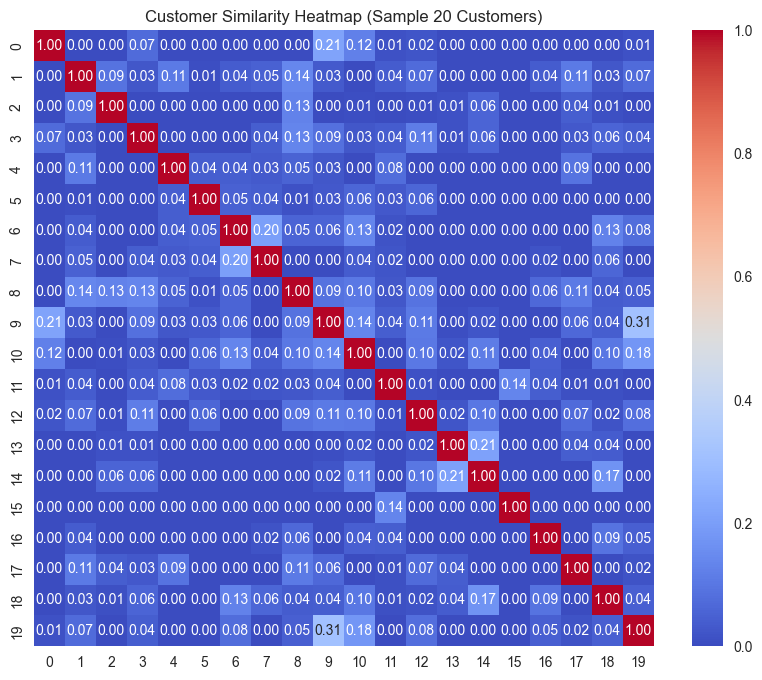

In [102]:
sample_idx = list(range(20))
plt.figure(figsize=(10, 8))
sns.heatmap(cf_system.customer_similarity[np.ix_(sample_idx, sample_idx)],
            cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Customer Similarity Heatmap (Sample 20 Customers)")
plt.show()


This heatmap shows the similarity between the top 20 most purchased products. Warmer colors indicate higher similarity, reflecting items that are frequently bought together and guiding item-based recommendations.


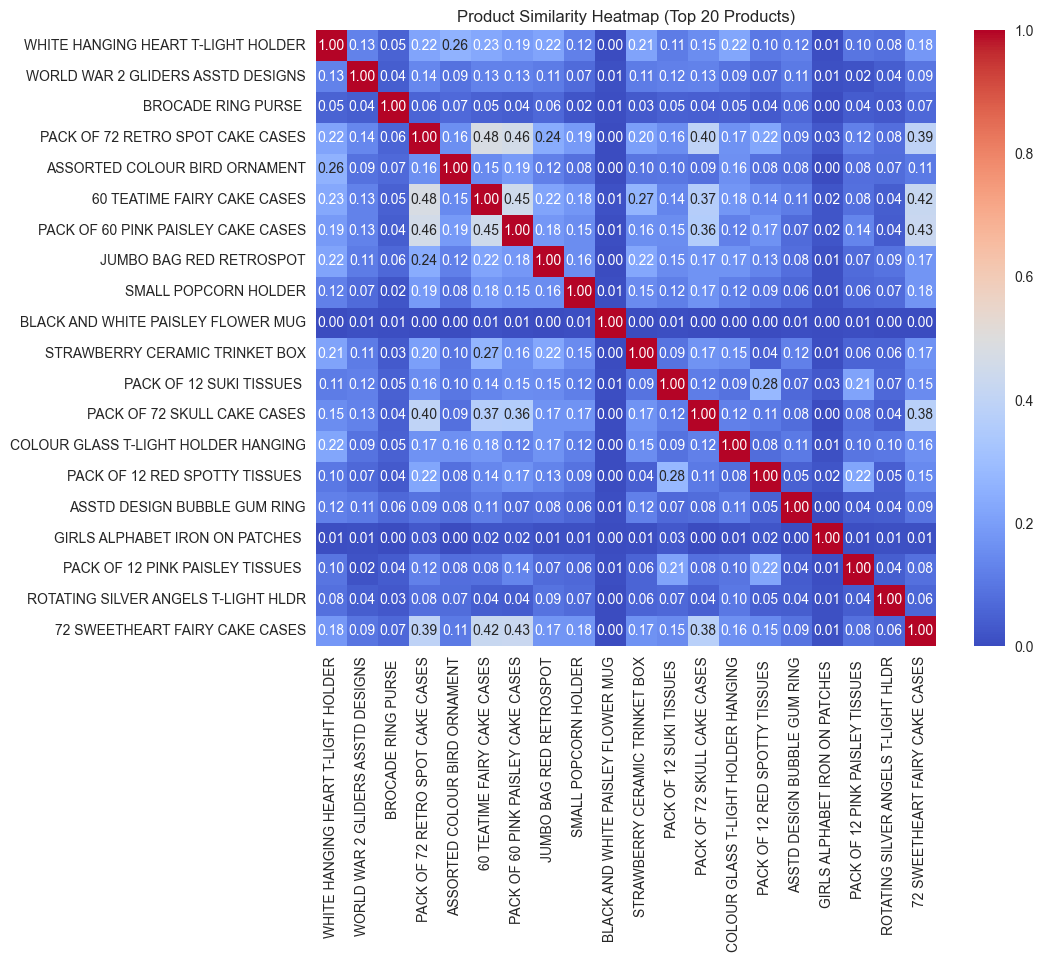

In [103]:
top_products = customer_product_matrix.sum().sort_values(ascending=False).index[:20]
product_idx = [customer_product_matrix.columns.get_loc(p) for p in top_products]

plt.figure(figsize=(10, 8))
sns.heatmap(cf_system.product_similarity[np.ix_(product_idx, product_idx)],
            xticklabels=top_products, yticklabels=top_products,
            cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Product Similarity Heatmap (Top 20 Products)")
plt.show()


### NMF Latent Factors & Sales Forecast

To extend it further to try if can use NMF for this online sales dataset, I refer to one paper from here https://www.jstage.jst.go.jp/article/ipsjjip/27/0/27_752/_pdf, and applied NMF to the Online Retail dataset to extract latent factors for products and customers. 

This script prepares a 3D tensor of product-customer-month purchase quantities, applies log-scaling, and evaluates different numbers of components (`K`) for Non-negative Matrix Factorization (NMF). The reconstruction error is computed for each `K` to help identify the optimal number of latent factors that best capture underlying purchase patterns.

For NMF, the MSE steadily decreases as `n_components` increases, but the rate of improvement slows down after around 20–25 components. To balance reconstruction accuracy and model simplicity, I have chosen n_components = 20.




In [104]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['Month'] = df_clean['InvoiceDate'].dt.to_period('M')

customers = df_clean['Customer ID'].unique()
products = df_clean['StockCode'].unique()
months = df_clean['Month'].sort_values().unique()
T = len(months)

customer_to_idx = {c: i for i, c in enumerate(customers)}
product_to_idx = {p: i for i, p in enumerate(products)}
month_to_idx = {m: i for i, m in enumerate(months)}

df_clean['CustomerIdx'] = df_clean['Customer ID'].map(customer_to_idx)
df_clean['ProductIdx'] = df_clean['StockCode'].map(product_to_idx)
df_clean['MonthIdx'] = df_clean['Month'].map(month_to_idx)

# Create 3D tensor: products x customers x months
Z = np.zeros((len(products), len(customers), T), dtype=np.float32)
indices = df_clean[['ProductIdx','CustomerIdx','MonthIdx']].values
quantities = df_clean['Quantity'].values
Z[indices[:,0], indices[:,1], indices[:,2]] = quantities

Z = np.log1p(Z)

K=5, Reconstruction Error: 327.1164
K=10, Reconstruction Error: 317.7828
K=15, Reconstruction Error: 310.5793
K=20, Reconstruction Error: 304.1210
K=25, Reconstruction Error: 298.5938
K=30, Reconstruction Error: 293.7279
K=35, Reconstruction Error: 289.1122
K=40, Reconstruction Error: 284.6874


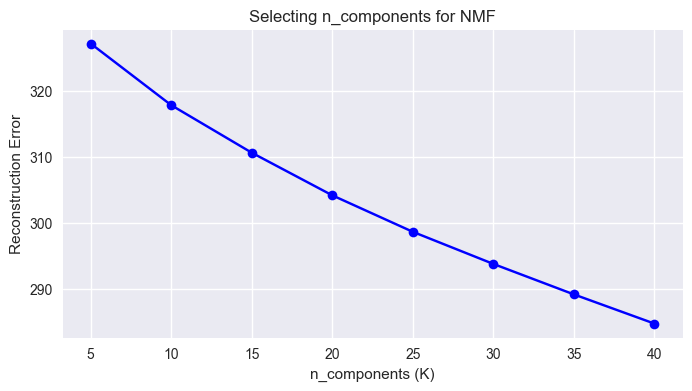

In [105]:
K_list = list(range(5, 41, 5))
errors = []
X_sample = Z[:, :, 0]

for K_try in K_list:
    nmf = NMF(n_components=K_try, init='nndsvda', random_state=42, max_iter=500)
    W = nmf.fit_transform(X_sample)
    H = nmf.components_
    recon_error = np.linalg.norm(X_sample - W @ H, ord='fro')
    print(f"K={K_try}, Reconstruction Error: {recon_error:.4f}")
    errors.append(recon_error)

plt.figure(figsize=(8,4))
plt.plot(K_list, errors, 'o-', color='blue')
plt.xlabel('n_components (K)')
plt.ylabel('Reconstruction Error')
plt.title('Selecting n_components for NMF')
plt.grid(True)
plt.show()


## Choosing Recommendation Threshold

The threshold for recommendation is currently set at 0.8 to reduce false positives, meaning that only the most confident predictions are recommended. 

## Latent Factors
- U latent factors (num_products × K)  
  Each row represents a product, and each column is a latent dimension, the latent dimensions capture hidden features of products that help explain purchasing patterns.

- V latent factors (K × num_customers)  
  Each column represents a customer, and each row is a latent dimension the factors capture hidden preferences of customers corresponding to the latent traits of products.


## Future Improvement

In future improvements, the threshold could be determined using the 95th percentile of predicted scores, which would select the top 5% of predictions and may lead to better overall recommendation performance.

## AUC Curve

An AUC of 0.81 means the model correctly distinguishes between customers who will purchase and those who won’t purchase about 81% of the time.




Month 1/12 processed.
Month 2/12 processed.
Month 3/12 processed.
Month 4/12 processed.
Month 5/12 processed.
Month 6/12 processed.
Month 7/12 processed.
Month 8/12 processed.
Month 9/12 processed.
Month 10/12 processed.
Month 11/12 processed.
Month 12/12 processed.
AUC: 0.8108


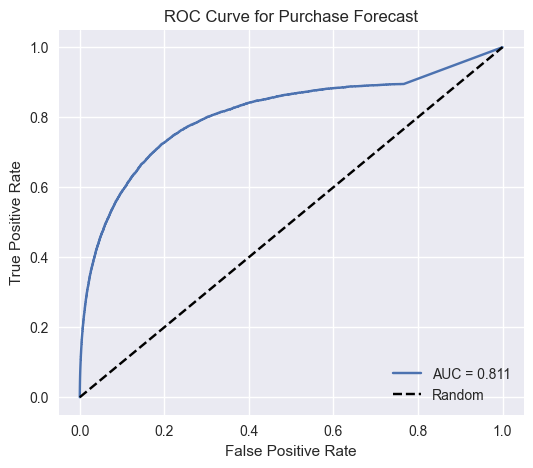

In [106]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- NMF per month ---
K = 20
U_seq, V_seq = [], []

for t in range(T-1):
    X_t = Z[:, :, t]
    nmf_model = NMF(n_components=K, init='nndsvda', random_state=42, max_iter=500)
    U_t = nmf_model.fit_transform(X_t)
    V_t = nmf_model.components_
    U_seq.append(U_t)
    V_seq.append(V_t)
    print(f"Month {t + 1}/{T-1} processed.")

U_seq = np.stack(U_seq)  # T x products x K
V_seq = np.stack(V_seq)  # T x K x customers


# --- Forecast next latent factors ---
def linear_forecast(matrix_seq):
    T, dim1, dim2 = matrix_seq.shape
    x = np.arange(T)
    X_design = np.vstack([x, np.ones_like(x)]).T
    forecast = np.zeros((dim1, dim2), dtype=np.float32)
    Y = matrix_seq.reshape(T, -1)

    for idx in range(Y.shape[1]):
        y = Y[:, idx]
        coeffs, _, _, _ = np.linalg.lstsq(X_design, y, rcond=None)
        forecast.flat[idx] = coeffs[0] * T + coeffs[1]

    return np.maximum(forecast, 0)


U_forecast = linear_forecast(U_seq)
V_forecast = linear_forecast(V_seq)

X_pred = U_forecast @ V_forecast

X_true = Z[:, :, -1]  # last month

y_true = (X_true > 0).astype(int).flatten()
y_score = X_pred.flatten()

fpr, tpr, _ = roc_curve(y_true, y_score)
auc_score = roc_auc_score(y_true, y_score)
print(f"AUC: {auc_score:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Purchase Forecast')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [107]:
threshold = 0.8
X_pred_binary = (X_pred > threshold).astype(np.int8)

prod_idx, cust_idx = np.nonzero(X_pred_binary)
df_pred = pd.DataFrame({
    'CustomerID': customers[cust_idx],
    'ProductID': products[prod_idx],
    'Predicted': 1
})

print(df_pred.shape)
print(df_pred.head(5))

(2738, 3)
   CustomerID ProductID  Predicted
0       14911     85048          1
1       17865     21232          1
2       13767     21232          1
3       15311     21232          1
4       14911     21232          1


# Visualization of NMF Latent Factor Forecast

This code selects the product–customer pair with the most non-zero purchase months and visualizes how the latent factors evolve over time.  


Selected Product 84879 and Customer 13089 with 13 non-zero months


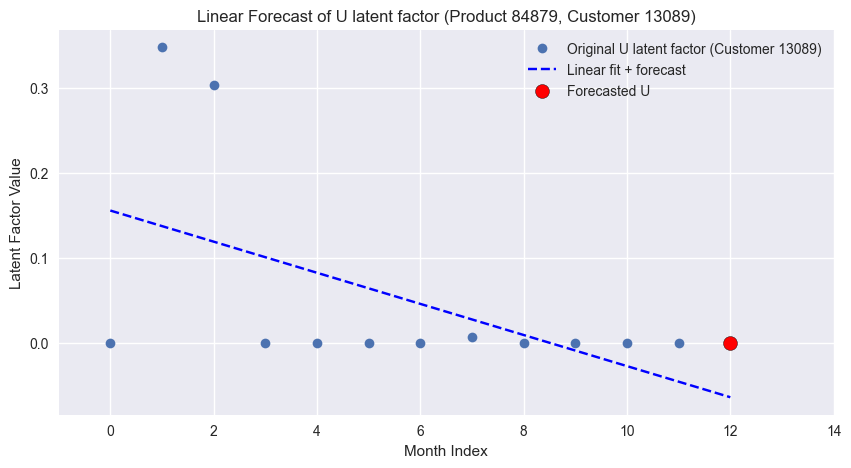

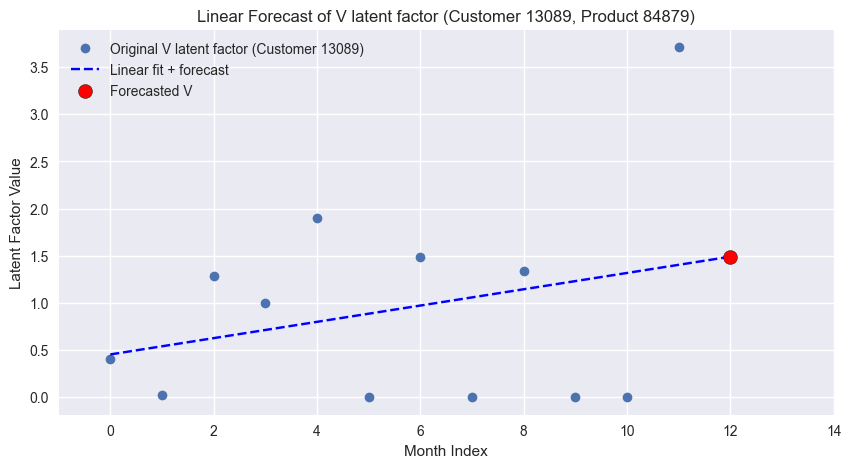

In [108]:
import matplotlib.pyplot as plt
import numpy as np

non_zero_counts = (Z > 0).sum(axis=2)
prod_idx, cust_idx = np.unravel_index(np.argmax(non_zero_counts), non_zero_counts.shape)
print(f"Selected Product {products[prod_idx]} and Customer {customers[cust_idx]} with {non_zero_counts[prod_idx, cust_idx]} non-zero months")

latent_idx = 0

latent_series_U = U_seq[:, prod_idx, latent_idx].copy()
latent_series_V = V_seq[:, latent_idx, cust_idx].copy()
months_idx = np.arange(len(latent_series_U))

forecast_U = U_forecast[prod_idx, latent_idx]
forecast_V = V_forecast[latent_idx, cust_idx]

coeff_U = np.polyfit(months_idx, latent_series_U, 1)
fit_line_U = coeff_U[0] * months_idx + coeff_U[1]

coeff_V = np.polyfit(months_idx, latent_series_V, 1)
fit_line_V = coeff_V[0] * months_idx + coeff_V[1]

months_idx_forecast = np.append(months_idx, len(months_idx))
fit_line_U_forecast = np.append(fit_line_U, coeff_U[0]*len(months_idx) + coeff_U[1])
fit_line_V_forecast = np.append(fit_line_V, coeff_V[0]*len(months_idx) + coeff_V[1])

plt.figure(figsize=(10,5))
plt.plot(months_idx, latent_series_U, 'o', label=f'Original U latent factor (Customer {customers[cust_idx]})')
plt.plot(months_idx_forecast, fit_line_U_forecast, 'b--', label='Linear fit + forecast')
plt.scatter(len(months_idx), forecast_U, color='red', s=100, edgecolors='black', zorder=5, label='Forecasted U')
plt.xlabel('Month Index')
plt.ylabel('Latent Factor Value')
plt.title(f'Linear Forecast of U latent factor (Product {products[prod_idx]}, Customer {customers[cust_idx]})')
plt.xlim(-1, len(months_idx) + 2)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(months_idx, latent_series_V, 'o', label=f'Original V latent factor (Customer {customers[cust_idx]})')
plt.plot(months_idx_forecast, fit_line_V_forecast, 'b--', label='Linear fit + forecast')
plt.scatter(len(months_idx), forecast_V, color='red', s=100, edgecolors='black', zorder=5, label='Forecasted V')
plt.xlabel('Month Index')
plt.ylabel('Latent Factor Value')
plt.title(f'Linear Forecast of V latent factor (Customer {customers[cust_idx]}, Product {products[prod_idx]})')
plt.xlim(-1, len(months_idx) + 2)
plt.legend()
plt.show()


## Heatmap of Predicted Purchases

This heatmap visualizes the predicted customer-product purchases from df_pred. Cells with darker blue indicate a higher likelihood that the customer will purchase the product, highlighting the model's top recommendations.


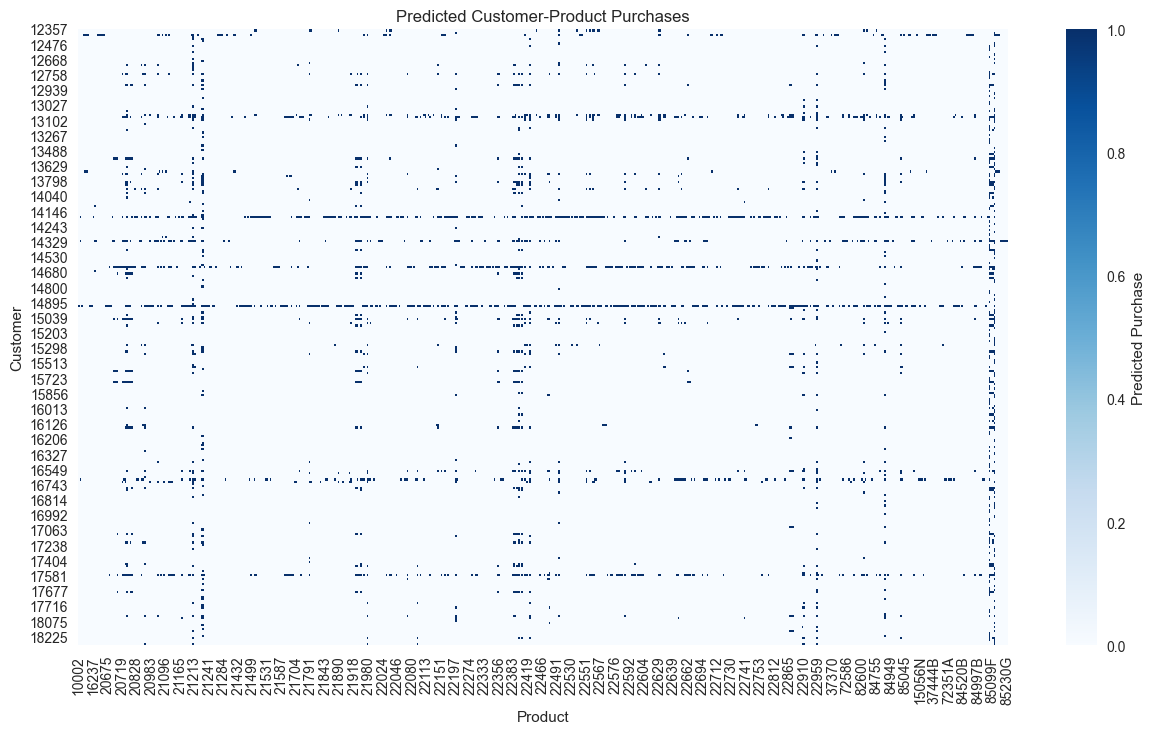

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

df_heat = df_pred.pivot(index='CustomerID', columns='ProductID', values='Predicted').fillna(0)

plt.figure(figsize=(15,8))
sns.heatmap(df_heat, cmap='Blues', cbar_kws={'label':'Predicted Purchase'})
plt.title("Predicted Customer-Product Purchases")
plt.xlabel("Product")
plt.ylabel("Customer")
plt.show()


# Shows all predicted products for Customer 14911

- **Actual Purchases:** Shows the historical purchase quantities of the customer, sorted from most to least purchased.  
- **Predicted Purchases:** Shows products the model predicts the customer is likely to buy, filtered by a score > 0.8 and sorted by predicted score.  
- **Observation:** Some predictions overlap with actual purchases (e.g., `PACK OF 72 RETRO SPOT CAKE CASES`), indicating the model captures known preferences. Duplicate descriptions like `21212` may need cleaning.


In [110]:
sample_customer_id = 14911
customer_idx = np.where(customers == sample_customer_id)[0][0]

customer_history = (
    df_clean[df_clean['Customer ID'] == sample_customer_id][['StockCode', 'Description', 'Quantity']]
    .groupby(['StockCode', 'Description']).sum().reset_index()
    .sort_values(by='Quantity', ascending=False)
)
print("-- Actual Purchases --")
print(customer_history.head(20))


pred_scores = X_pred[:, customer_idx]

pred_mask = pred_scores > 0.8
pred_products_idx = np.where(pred_mask)[0]
pred_scores_filtered = pred_scores[pred_mask]

customer_pred = pd.DataFrame({
    'ProductID': products[pred_products_idx],
    'PredictedScore': pred_scores_filtered
})


product_names = df_clean[['StockCode', 'Description']].drop_duplicates()
customer_pred = customer_pred.merge(product_names, left_on='ProductID', right_on='StockCode', how='left')

customer_pred = customer_pred.sort_values(by='PredictedScore', ascending=False).reset_index(drop=True)

print("-- Predicted Purchases (Top 20) --")
print(customer_pred[['ProductID', 'Description', 'PredictedScore']].head(20))



-- Actual Purchases --
     StockCode                          Description  Quantity
1492     84991          60 TEATIME FAIRY CAKE CASES       888
263      21212     PACK OF 72 RETRO SPOT CAKE CASES       648
1308     22950         36 DOILIES VINTAGE CHRISTMAS       636
1294     22909  SET OF 20 VINTAGE CHRISTMAS NAPKINS       540
793      22197                 SMALL POPCORN HOLDER       520
1786    85123A   WHITE HANGING HEART T-LIGHT HOLDER       500
1003     22489       PACK OF 12 TRADITIONAL CRAYONS       480
794      22198                LARGE POPCORN HOLDER        438
1062     22560           TRADITIONAL MODELLING CLAY       432
1310     22952      60 CAKE CASES VINTAGE CHRISTMAS       432
947      22423             REGENCY CAKESTAND 3 TIER       425
1417     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS       384
649      21977   PACK OF 60 PINK PAISLEY CAKE CASES       384
6        16033                MINI HIGHLIGHTER PENS       360
1737    84970S    HANGING HEART ZINC T-LIGHT HO

## Summary

This project was my attempt to apply unsupervised machine learning techniques to the UCI Online Retail Dataset. It was quite challenging at first, but I learned a lot along the way. I started by cleaning the messy dataset, removing about 25% of bad data, which was more than I expected. After that, I explored customer purchasing patterns through visualizations and used RFM analysis to understand customer behavior in terms of recency, frequency, and monetary value. To handle the high dimensionality of the data, I applied PCA for dimensionality reduction. I then tried both K-Means and Agglomerative clustering to segment customers into three groups. Additionally, I built collaborative filtering recommendation systems, though the data was extremely sparse, with 98.5% missing values.

The key findings from this project were insightful. I identified three distinct customer segments: high-value loyal customers, moderate occasional buyers, and low-value at-risk customers. Between the clustering methods, Agglomerative clustering performed slightly better than K-Means, achieving a silhouette score of 0.41 compared to 0.39. In the recommendation system, user-based collaborative filtering performed much better than item-based, with an RMSE of 2.02 versus 19.83. Overall, the clustering produced clear and interpretable groups, which was helpful for understanding customer behavior. However, the recommendation task was challenging due to the high sparsity of the data, as most customers purchased only a few items.

## Conclusion

This project taught me that real-world data is often messy and difficult to work with. While I was able to successfully identify customer segments that make business sense, I realized there is still a lot more to learn about handling sparse data and selecting the most suitable algorithms. I learned that data preprocessing is far more important than I initially thought, and that different clustering algorithms can provide different insights into the same dataset. Sparsity is a major issue in recommendation systems, and visualization plays a critical role in understanding how algorithms operate and what patterns they capture.

## Next Step
For the next steps, I plan to explore NMF further for forecasting, which I found particularly interesting. I implemented NMF on a 3D tensor of products, customers, and months, then extract latent factors. Inspired by a paper I read, this approach worked reasonably well, I believe there is still much more to explore in this area, including optimizing the latent factors and experimenting with different tensor factorization techniques.

# reference
https://www.jstage.jst.go.jp/article/ipsjjip/27/0/27_752/_pdf